In [11]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
from numba import jit

## Stimulus generation (cf. Figure 1B and 1D of Bhattacharyya et. al 2017)

In [12]:
def generate_stimulus(stim_size=1, speed=1, length=10, dt=0.1, init_distance=50):
    timesteps = np.arange(int(length/dt))*dt
    distances = init_distance - timesteps*speed
    angles = np.arctan2(stim_size/2, distances)*2
    angles_degrees = angles/np.pi*180
    return timesteps, angles_degrees, distances

[ 131.57894737   65.78947368   44.64285714   33.78378378   26.88172043
   22.52252252]


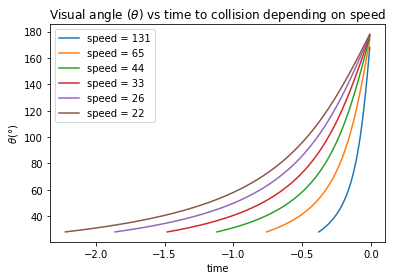

In [13]:
# these values are taken from Bhattacharyya et. al 2017:
LV_vals = np.array([0.19, 0.38, 0.56, 0.74, 0.93, 1.11])
stim_size = 25
speeds = 1/(LV_vals/stim_size)
print(speeds)

#plt.figure(figsize=(8,8))
for speed in speeds:
    t, stims, dists = generate_stimulus(stim_size=stim_size, speed=speed, dt=0.01)
    collision_idx = np.argmin(np.abs(dists))
    t_collision = t[collision_idx]
    stim_collision = stims[collision_idx]
    
    before_collision_mask = t<t_collision
    t_to_collision = t[before_collision_mask] - t_collision
    stim_to_collision = stims[before_collision_mask]
    plt.plot(t_to_collision, stim_to_collision, label='speed = ' + str(int(speed)))
plt.xlabel('time')
plt.ylabel(r'$\theta (\degree)$')
plt.title(r'Visual angle ($\theta$) vs time to collision depending on speed')
plt.legend()
#print(dists)

## Linear function of visual angle

In [14]:
def f_theta_linear(theta, m, b):
    return theta*m + b

def transform_stim(stim_size, speed, length, dt, m=1.5, b=0):
    t, stims, dists = generate_stimulus(stim_size=stim_size, speed=speed, length=length, dt=dt)
    collision_idx = np.argmin(np.abs(dists))
    t_collision = t[collision_idx]
    stim_collision = stims[collision_idx]
    before_collision_mask = t<t_collision
    t_to_collision = t[before_collision_mask] - t_collision
    stim_to_collision = stims[before_collision_mask]
    transformed_stim_to_collision = f_theta_linear(stim_to_collision, m=m, b=b)
    transformed_stims = f_theta_linear(stims, m=m, b=b)
    return t, stims, transformed_stims, dists, t_to_collision, transformed_stim_to_collision

## Leaky Integrate-and-Fire model of the Mauthner cell (adopted from Koyama et. al 2016)

In [15]:
def lif_dynamics(tau_m, e_l, r_m, stimulus, noise, v_t, dt, total_time, init_vm_std):
    ntime_steps = int(total_time/dt)
    time_points = np.arange(ntime_steps)*dt
    v_m = np.zeros(ntime_steps)
    v_m[0] = np.random.normal(loc=e_l, scale=init_vm_std)
    t_spks = []
    idx_spks = []
    # integration:
    t = 1
    while t < ntime_steps:
        v_m[t] = v_m[t - 1] + dt*(- (v_m[t - 1] - e_l) + r_m*stimulus[t])/tau_m + noise[t]
        if v_m[t] > v_t:
            v_m[t] = e_l
            t_spks.append(t*dt)
            idx_spks.append(t)
        t = t + 1

    return time_points, v_m, t_spks, idx_spks

In [16]:
def ffi_model(tau_m, e_l, r_m, stimulus, noise_exc, noise_inh, v_t, dt, total_time, init_vm_std, vt_std, rho_null,
              tau_inh):
    ntime_steps = int(total_time/dt)
    time_points = np.arange(ntime_steps)*dt
    v_m = np.zeros(ntime_steps)
    v_m[0] = np.random.normal(loc=e_l, scale=init_vm_std)
    v_t = np.random.normal(loc=v_t, scale=vt_std, size=ntime_steps)
    rho_inh = np.zeros(ntime_steps)
    t_spks = []
    idx_spks = []
    # integration:
    t = 1
    while t < ntime_steps:
        # calculate activation of inhibitory population
        rho_inh[t] = rho_inh[t-1] + dt*(rho_null - rho_inh[t-1]  + stimulus[t])/tau_inh + noise_inh[t]
        # calculate lif dynamics with inhibitory input
        v_m[t] = v_m[t - 1] + dt*(- (v_m[t - 1] - e_l) + r_m*stimulus[t] - rho_inh[t-1])/tau_m + noise_exc[t]
        if v_m[t] > v_t:
            v_m[t] = e_l
            t_spks.append(t*dt)
            idx_spks.append(t)
        t = t + 1
    
    return time_points, v_m, t_spks, idx_spks, rho_inh

In [17]:
@jit
def jit_lif_dynamics(tau_m, e_l, r_m, stimulus, noise, v_t, dt, total_time, init_vm_std):
    ntime_steps = int(total_time/dt)
    time_points = np.arange(ntime_steps)*dt
    v_m = np.zeros(ntime_steps)
    v_m[0] = np.random.normal(loc=e_l, scale=init_vm_std)
    t_spks = []
    idx_spks = []
    # integration:
    t = 1
    while t < ntime_steps:
        v_m[t] = v_m[t - 1] + dt*(- (v_m[t - 1] - e_l) + r_m*stimulus[t])/tau_m + noise[t]
        if v_m[t] > v_t:
            v_m[t] = e_l
            t_spks.append(t*dt)
            idx_spks.append(t)
        t = t + 1

    return time_points, v_m, t_spks, idx_spks

@jit
def jit_ffi_model(tau_m, e_l, r_m, stimulus, noise_exc, noise_inh, v_t, dt, total_time, init_vm_std, vt_std, rho_null,
                  tau_inh, rho_scale):
    ntime_steps = int(total_time/dt)
    time_points = np.arange(ntime_steps)*dt
    v_m = np.zeros(ntime_steps)
    v_m[0] = np.random.normal(loc=e_l, scale=init_vm_std)
    v_t = np.random.normal(loc=v_t, scale=vt_std, size=ntime_steps)
    rho_inh = np.zeros(ntime_steps)
    t_spks = []
    idx_spks = []
    # integration:
    t = 1
    while t < ntime_steps:
        # calculate activation of inhibitory population
        rho_inh[t] = rho_inh[t-1] + dt*(rho_null - rho_inh[t-1] + rho_scale*stimulus[t])/tau_inh + noise_inh[t]
        # calculate lif dynamics with inhibitory input
        v_m[t] = v_m[t - 1] + dt*(- (v_m[t - 1] - e_l) + r_m*stimulus[t] - rho_inh[t-1])/tau_m + noise_exc[t]
        if v_m[t] > v_t[t]:
            v_m[t] = e_l
            t_spks.append(t*dt)
            idx_spks.append(t)
        t = t + 1
    
    return time_points, v_m, t_spks, idx_spks, rho_inh

In [18]:
def calc_response(params):
    # sample lv values uniformly between 0.1 and 1.2
    lv = np.random.rand()*1.1 + 0.1
    # sample stimulus sizes (L) uniformly between 10 and 25
    stim_size = np.random.rand()*15 + 10
    speed = 1/(lv/stim_size)
    t, stims, tstims, dists, t_to_coll, tstim_to_coll = transform_stim(stim_size, speed, params['total_time'],
                                                                       params['dt'], params['m'], params['b'])

    stimulus = tstims*1e-11
    sigma_exc = params['noise_std_exc'] * np.sqrt(params['dt'])
    sigma_inh = params['noise_std_inh'] * np.sqrt(params['dt'])
    noise_exc = np.random.normal(loc=0.0, scale=sigma_exc, size=len(stimulus))
    noise_inh = np.random.normal(loc=0.0, scale=sigma_inh, size=len(stimulus))

    #np.random.seed(1)
    time, v_m, spks, spk_idc, rho_inh = jit_ffi_model(params['tau_m'], params['e_l'], params['r_m'], stimulus, noise_exc,
                                                      noise_inh, params['v_t'], params['dt'], params['total_time'],
                                                      params['init_vm_std'], params['vt_std'], params['rho_null'],
                                                      params['tau_inh'], params['rho_scale'])
    if not len(spks)==0:
        first_spike = spks[0]
        first_spike_idx = spk_idc[0]
    else:
        first_spike = 0
        first_spike_idx = 0
        
    if not first_spike_idx >= len(t_to_coll):
        resp_in_t_to_coll = t_to_coll[first_spike_idx]
    else:
        resp_in_t_to_coll = 0
        
    return stims[first_spike_idx], dists[first_spike_idx], first_spike, lv, stim_size, speed, resp_in_t_to_coll

In [19]:
tau_m = 0.023
e_l = -0.079
r_m = 10*1e6 # MOhm
v_t = -0.061
init_vm_std = 0.001
vt_std = 0.001

rho_null = 0.00
tau_inh = 0.010
rho_scale = 7.5*1e6

dt = 0.001
total_time = 5

noise_std_exc = 5*1e-3
noise_std_inh = 5*1e-3
n_timepoints = int(total_time/dt)

# generate looming stimulus
LV_vals = np.array([0.19, 0.38, 0.56, 0.74, 0.93, 1.11])
stim_size = 10
speeds = 1/(LV_vals/stim_size)
speed = speeds[2]

m = 5.5
b = 5

t, stims, tstims, dists, t_to_collision, transformed_stim_to_collision = transform_stim(stim_size, speed, total_time, dt, m, b)

stimulus = tstims*1e-11
sigma_exc = noise_std_exc * np.sqrt(dt)
sigma_inh = noise_std_inh * np.sqrt(dt)
noise_exc = np.random.normal(loc=0.0, scale=sigma_exc, size=n_timepoints)
noise_inh = np.random.normal(loc=0.0, scale=sigma_inh, size=n_timepoints)
time, v_m, spks, spk_idc, rho_inh = jit_ffi_model(tau_m, e_l, r_m, stimulus, noise_exc, noise_inh, v_t, dt, total_time,
                                                  init_vm_std, vt_std, rho_null, tau_inh, rho_scale)
first_spike = spks[0]
first_spike_idx = spk_idc[0]

Response angle at first spike: 111.96130002 degree
Distance at first spike: 3.375 mm


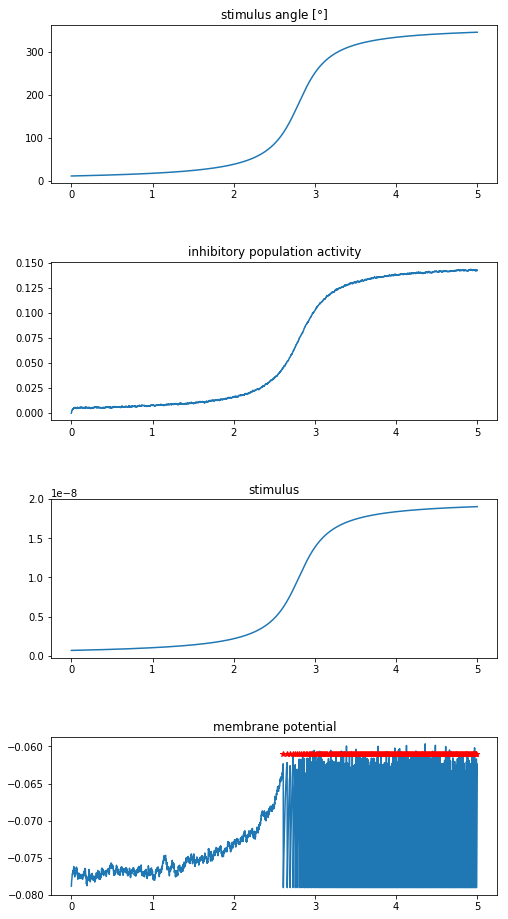

In [20]:
fig, axes = plt.subplots(4, 1, figsize=(8,16))
axes[0].plot(time, stims)
axes[0].set_title(r'stimulus angle [$ \degree $]')
axes[1].plot(time, rho_inh)
axes[1].set_title('inhibitory population activity')
axes[2].plot(time, stimulus)
axes[2].set_title('stimulus')
axes[3].plot(time, v_m)
axes[3].set_title('membrane potential')
if not len(spks) == 0:
    axes[3].plot(spks, np.ones(len(spks))*v_t, 'r*')
plt.subplots_adjust(hspace=0.5)
print('Response angle at first spike: ' + str(stims[first_spike_idx]) + ' degree')
print('Distance at first spike: ' + str(dists[first_spike_idx]) + ' mm')

## One parameter set example

Mean visual angle: 40.2225811421
Mean distance: 24.5205853869
Mean reaction time: 1.017746
resp in ttc: -0.392


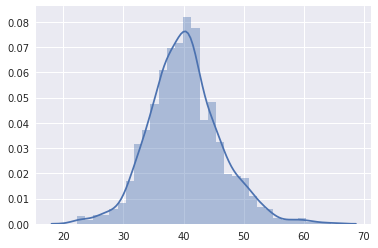

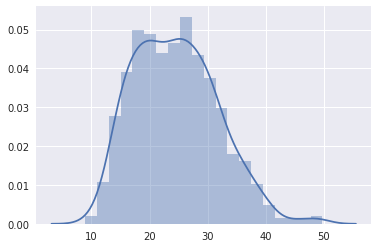

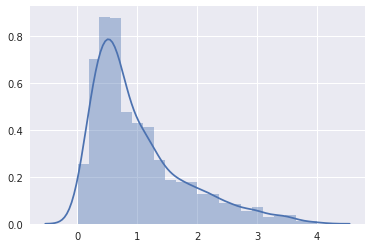

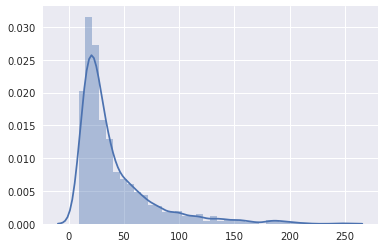

In [21]:
# generate looming stimulus
LV_vals = np.array([0.19, 0.38, 0.56, 0.74, 0.93, 1.11])
stim_size = 10
speeds = 1/(LV_vals/stim_size)
speed = speeds[1]

params = {'tau_m': 0.023,
          'e_l': -0.079,
          'r_m': 10*1e6,
          'v_t': -0.061,
          'init_vm_std': 0.001,
          'vt_std': 0.004,
          'rho_null': 0.01,
          'tau_inh': 0.010,
          'rho_scale': 8*1e5,
          'dt': 0.001,
          'total_time': 5,
          'noise_std_exc': 5*1e-3,
          'noise_std_inh': 5*1e-3,
          'n_timepoints': int(total_time/dt),
          'm': 5,
          'b': 5}

nruns = 1000
rstims = np.zeros(nruns)
rdists = np.zeros(nruns)
reaction_times = np.zeros(nruns)
speeds = np.zeros(nruns)
for i in np.arange(nruns):
    rstims[i], rdists[i], reaction_times[i], lv, stim_size, speeds[i], resp_in_t_to_coll = calc_response(params)

sns.set()
sns.distplot(rstims)
print('Mean visual angle: ' + str(np.mean(rstims)))
plt.figure()
sns.distplot(rdists)
print('Mean distance: ' + str(np.mean(rdists)))
plt.figure()
sns.distplot(reaction_times)
plt.figure()
sns.distplot(speeds)
print('Mean reaction time: ' + str(np.mean(reaction_times)))
print('resp in ttc: ' + str(resp_in_t_to_coll))

# Analyzing the effects of parameters of the inhibitory population

## Scaling of stimulus input

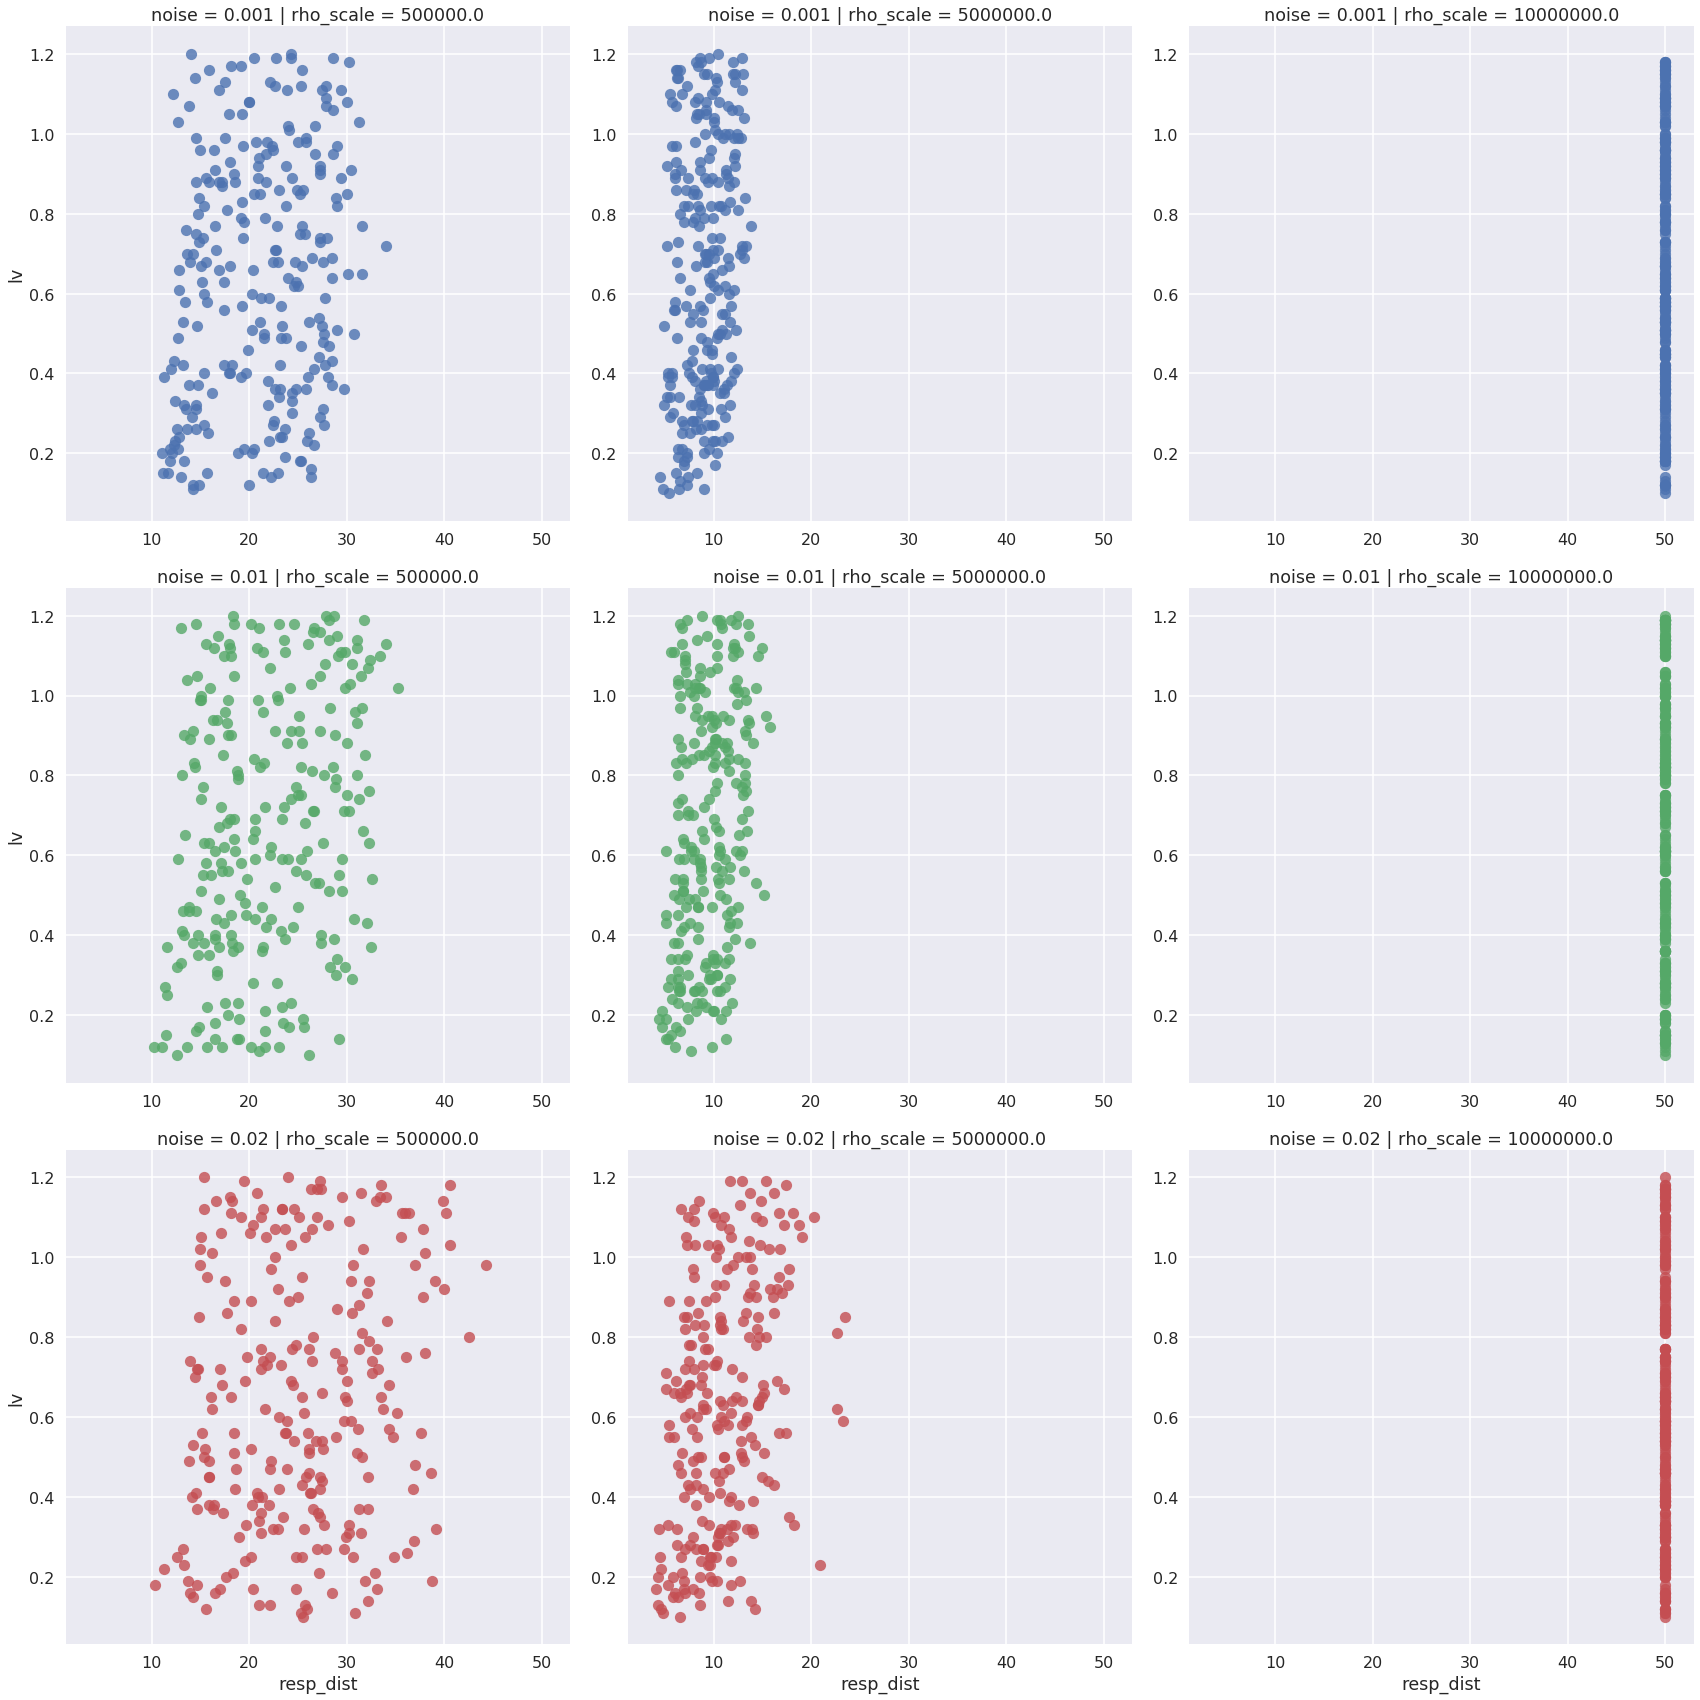

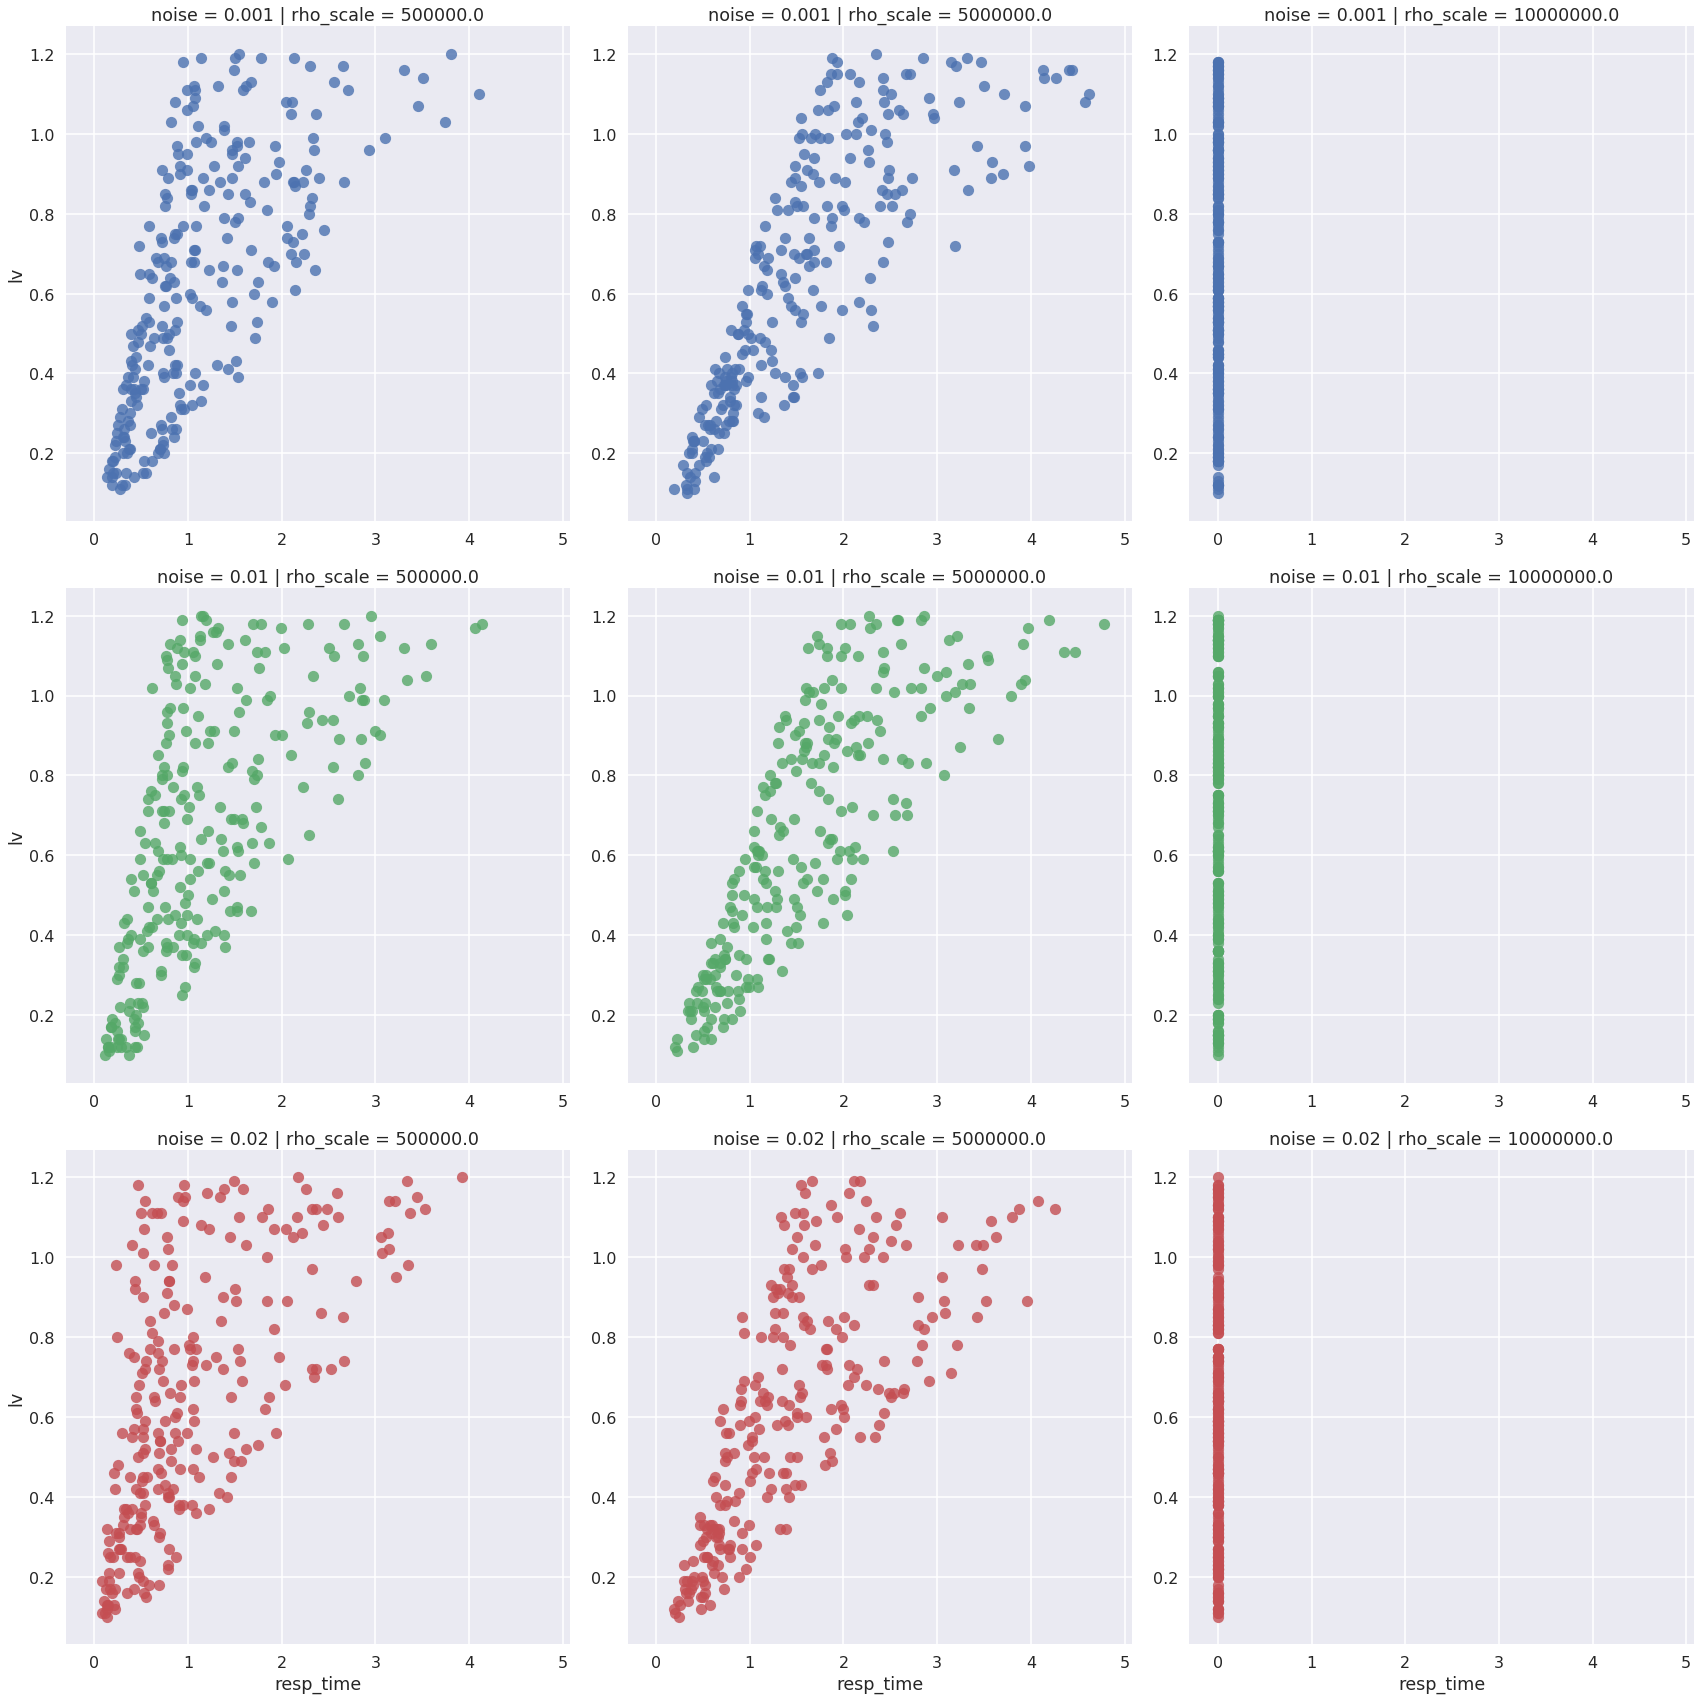

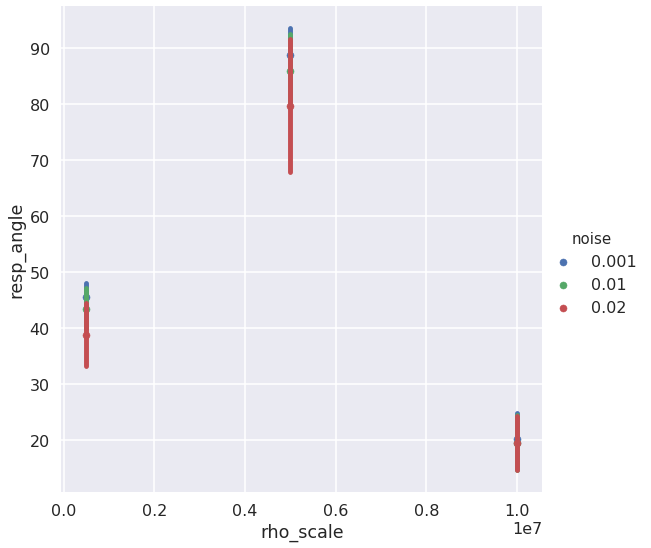

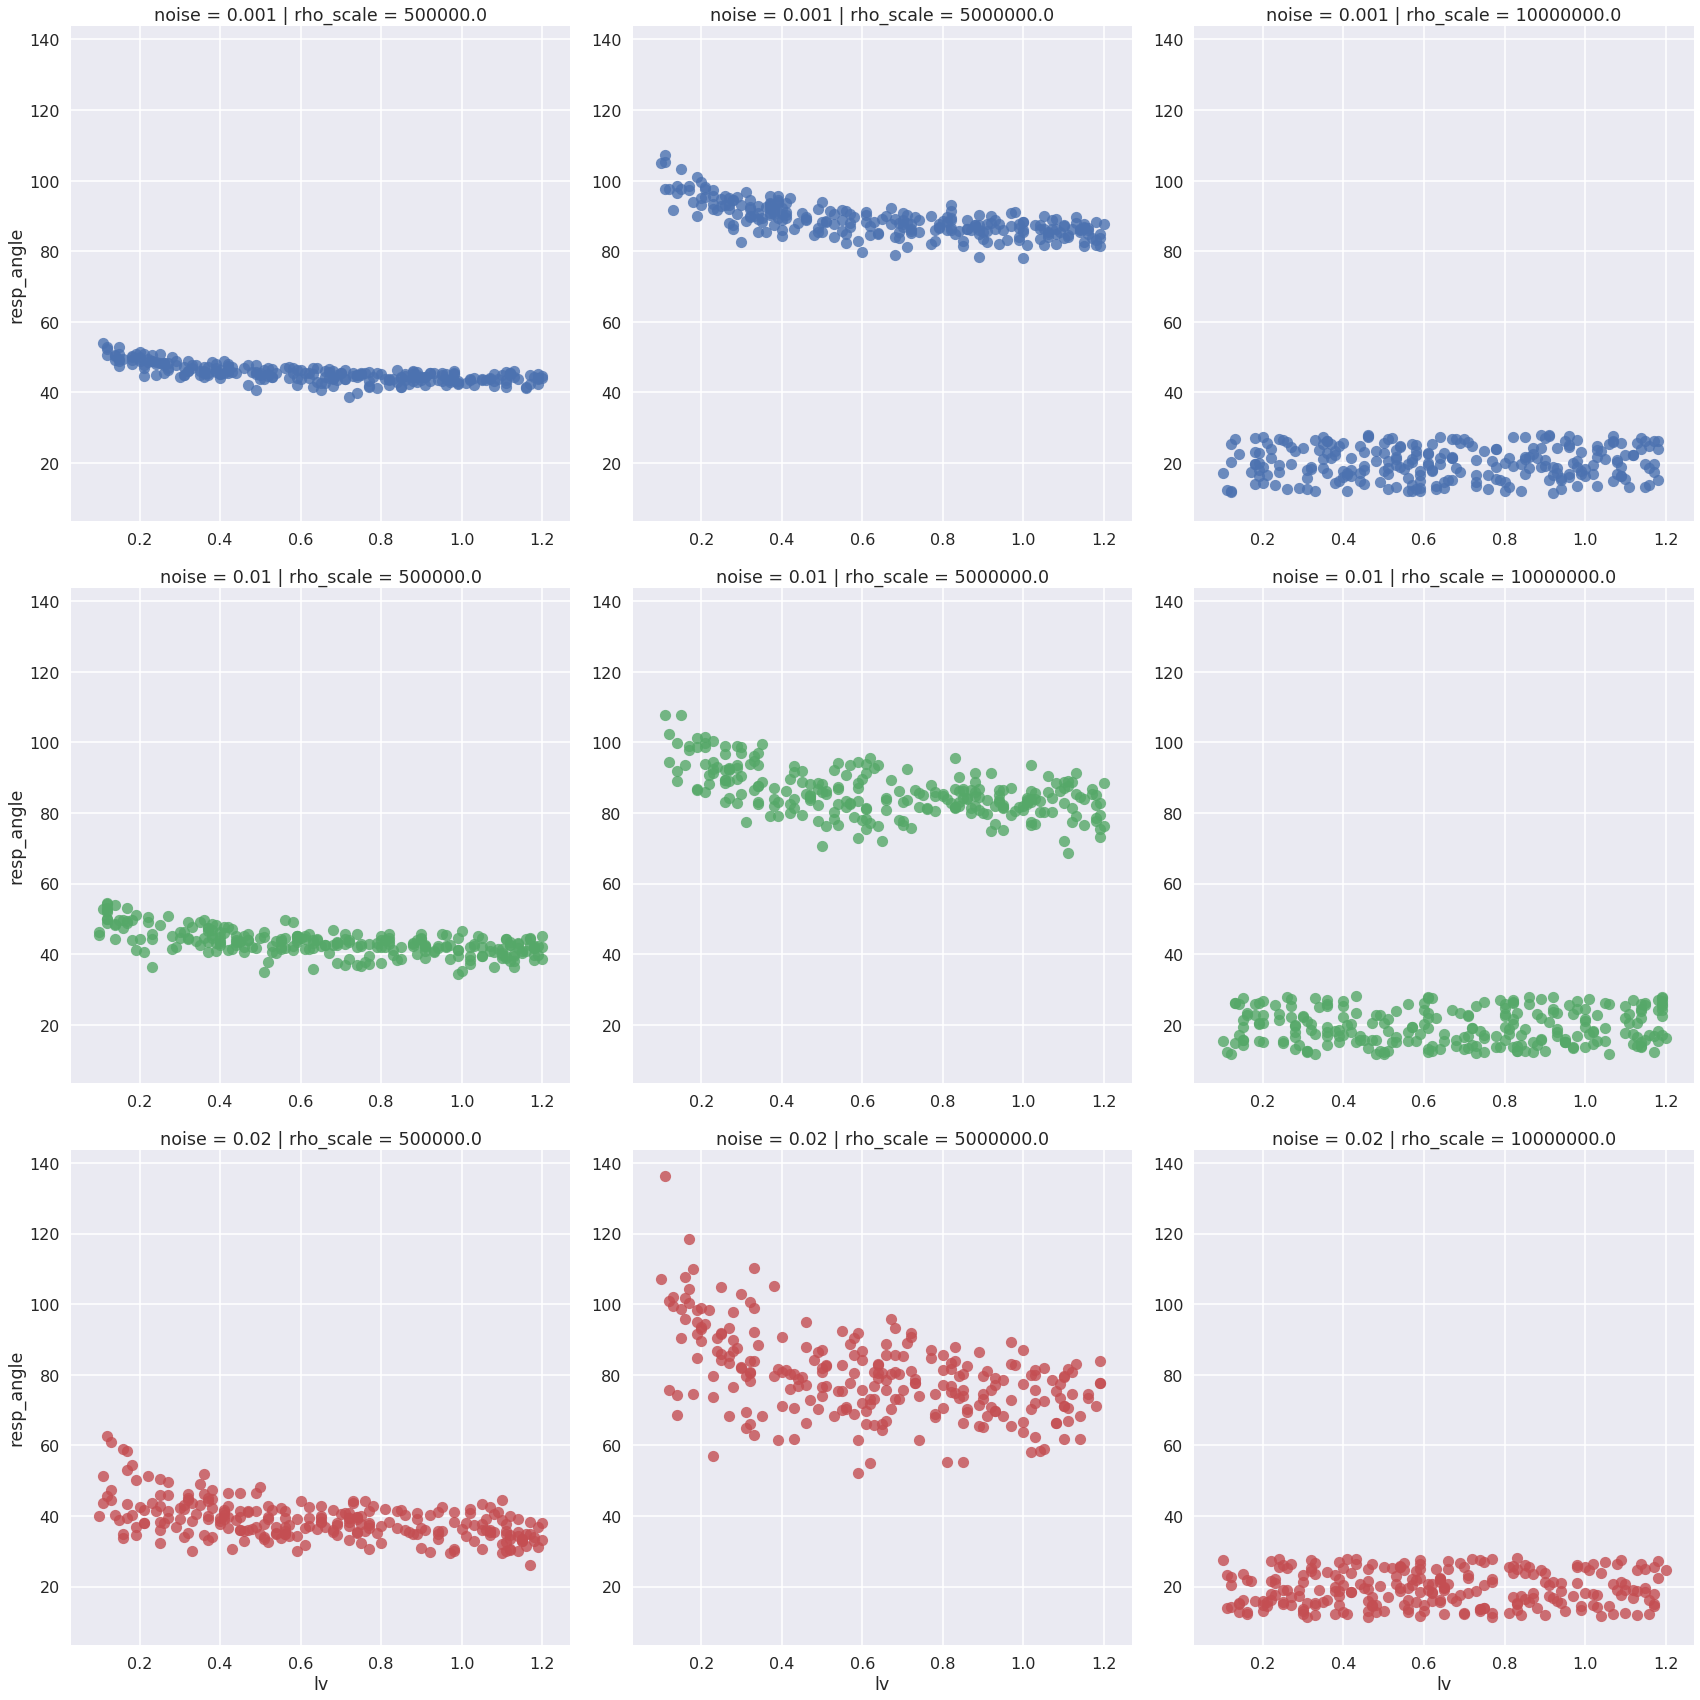

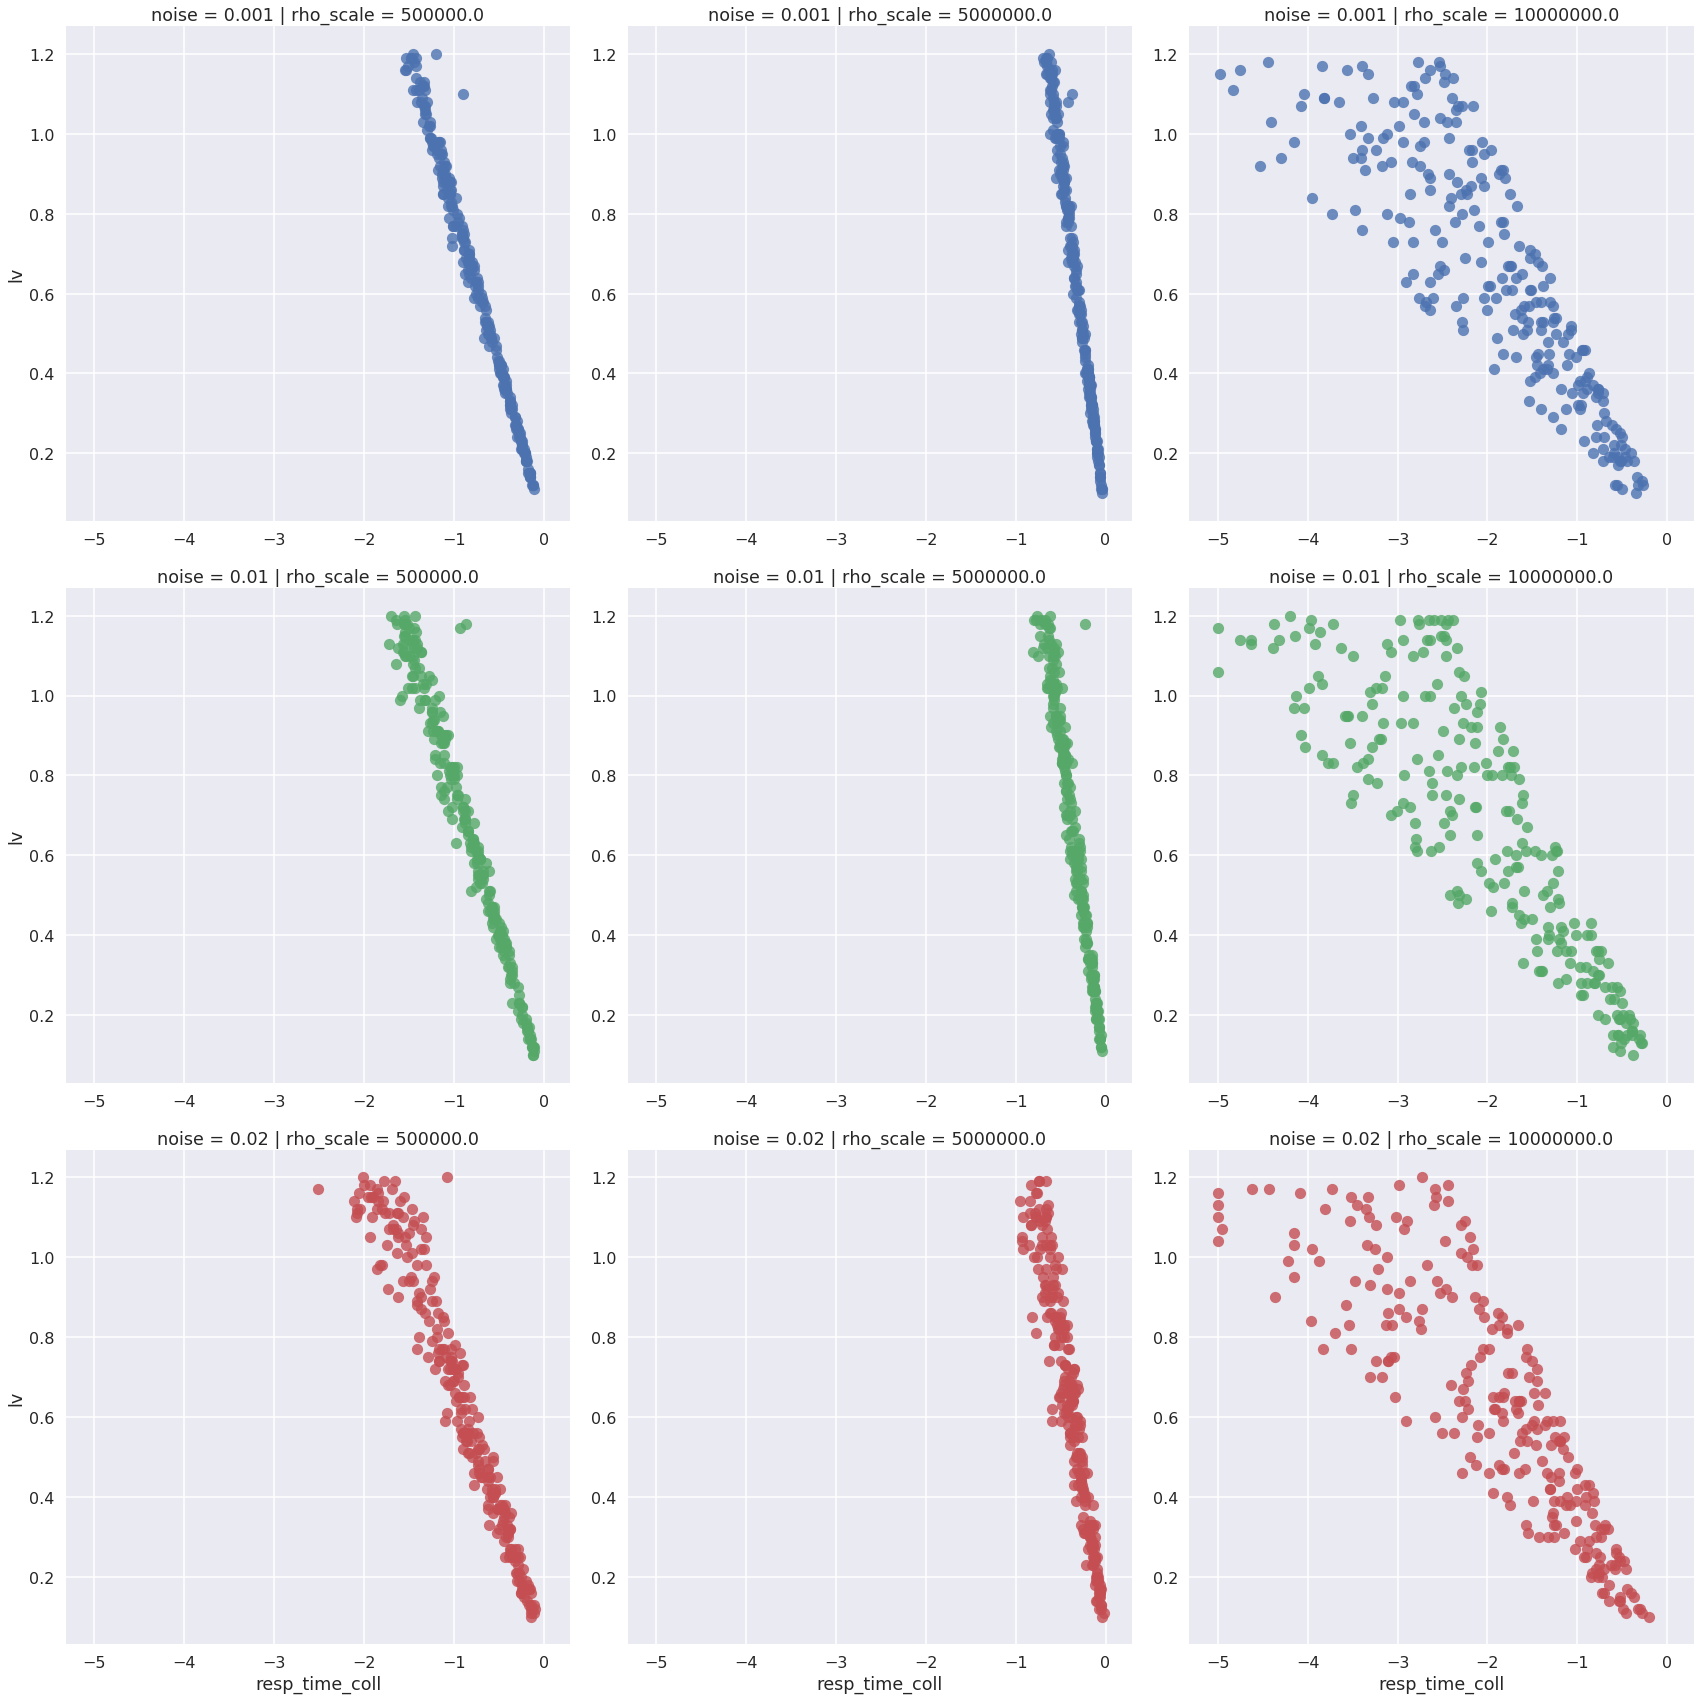

In [29]:
params = {'tau_m': 0.023,
          'e_l': -0.079,
          'r_m': 10*1e6, # MOhm
          'v_t': -0.061,
          'init_vm_std': 0.001,
          'vt_std': 0.001,
          'rho_null': 0.001,
          'tau_inh': 0.010,
          'rho_scale': 8*1e5,
          'dt': 0.001,
          'total_time': 5,
          'noise_std_exc': 5*1e-3,
          'noise_std_inh': 5*1e-3,
          'n_timepoints': int(total_time/dt),
          'm': 4,
          'b': 5}

rho_vals = np.array([5, 50, 100])*1e5
noisevals = np.array([1, 10, 20])*1e-3
nruns = 250
data_cols = ['resp_angle', 'resp_dist', 'resp_time', 'lv', 'stim_size', 'speed', 'rho_scale', 'noise', 'resp_time_coll']
data_dict = dict([(col_name, []) for col_name in data_cols])

for noise_idx, noise in enumerate(noisevals):
    params['noise_std_exc'] = noise
    for rho_idx, rho_val in enumerate(rho_vals):
        params['rho_scale'] = rho_val
        for i in np.arange(nruns):
            resp_angle, resp_dist, resp_time, lv, stim_size, speed, resp_time_coll = calc_response(params)
            resp_angle = np.round(resp_angle, decimals=1)
            resp_dist = np.round(resp_dist, decimals=1)
            resp_time = np.round(resp_time, decimals=3)
            lv = np.round(lv, decimals=2)
            stim_size = np.round(stim_size, decimals=1)
            speed = np.round(speed, decimals=1)
            resp_time_coll = np.round(resp_time_coll, decimals=3)
            result_values = [resp_angle, resp_dist, resp_time, lv, stim_size, speed, rho_val, noise, resp_time_coll]
            for col, value in zip(data_cols, result_values):
                data_dict[col].append(value)
                
df = pd.DataFrame(data_dict)
sns.set('poster')
g = sns.lmplot(x='resp_dist', y='lv', col='rho_scale', row='noise', hue='noise', data=df, fit_reg=False, size=8)
g = sns.lmplot(x='resp_time', y='lv', col='rho_scale', row='noise', hue='noise', data=df, fit_reg=False, size=8)
g = sns.lmplot(x='rho_scale', y='resp_angle', hue='noise', data=df, fit_reg=False, size=8, x_estimator=np.mean, x_ci='sd')
g = sns.lmplot(x='lv', y='resp_angle', hue='noise', row='noise', col='rho_scale', data=df, fit_reg=False, size=8)
g = sns.lmplot(x='resp_time_coll', y='lv', hue='noise', row='noise', col='rho_scale', data=df, fit_reg=False, size=8)

## Default activity level

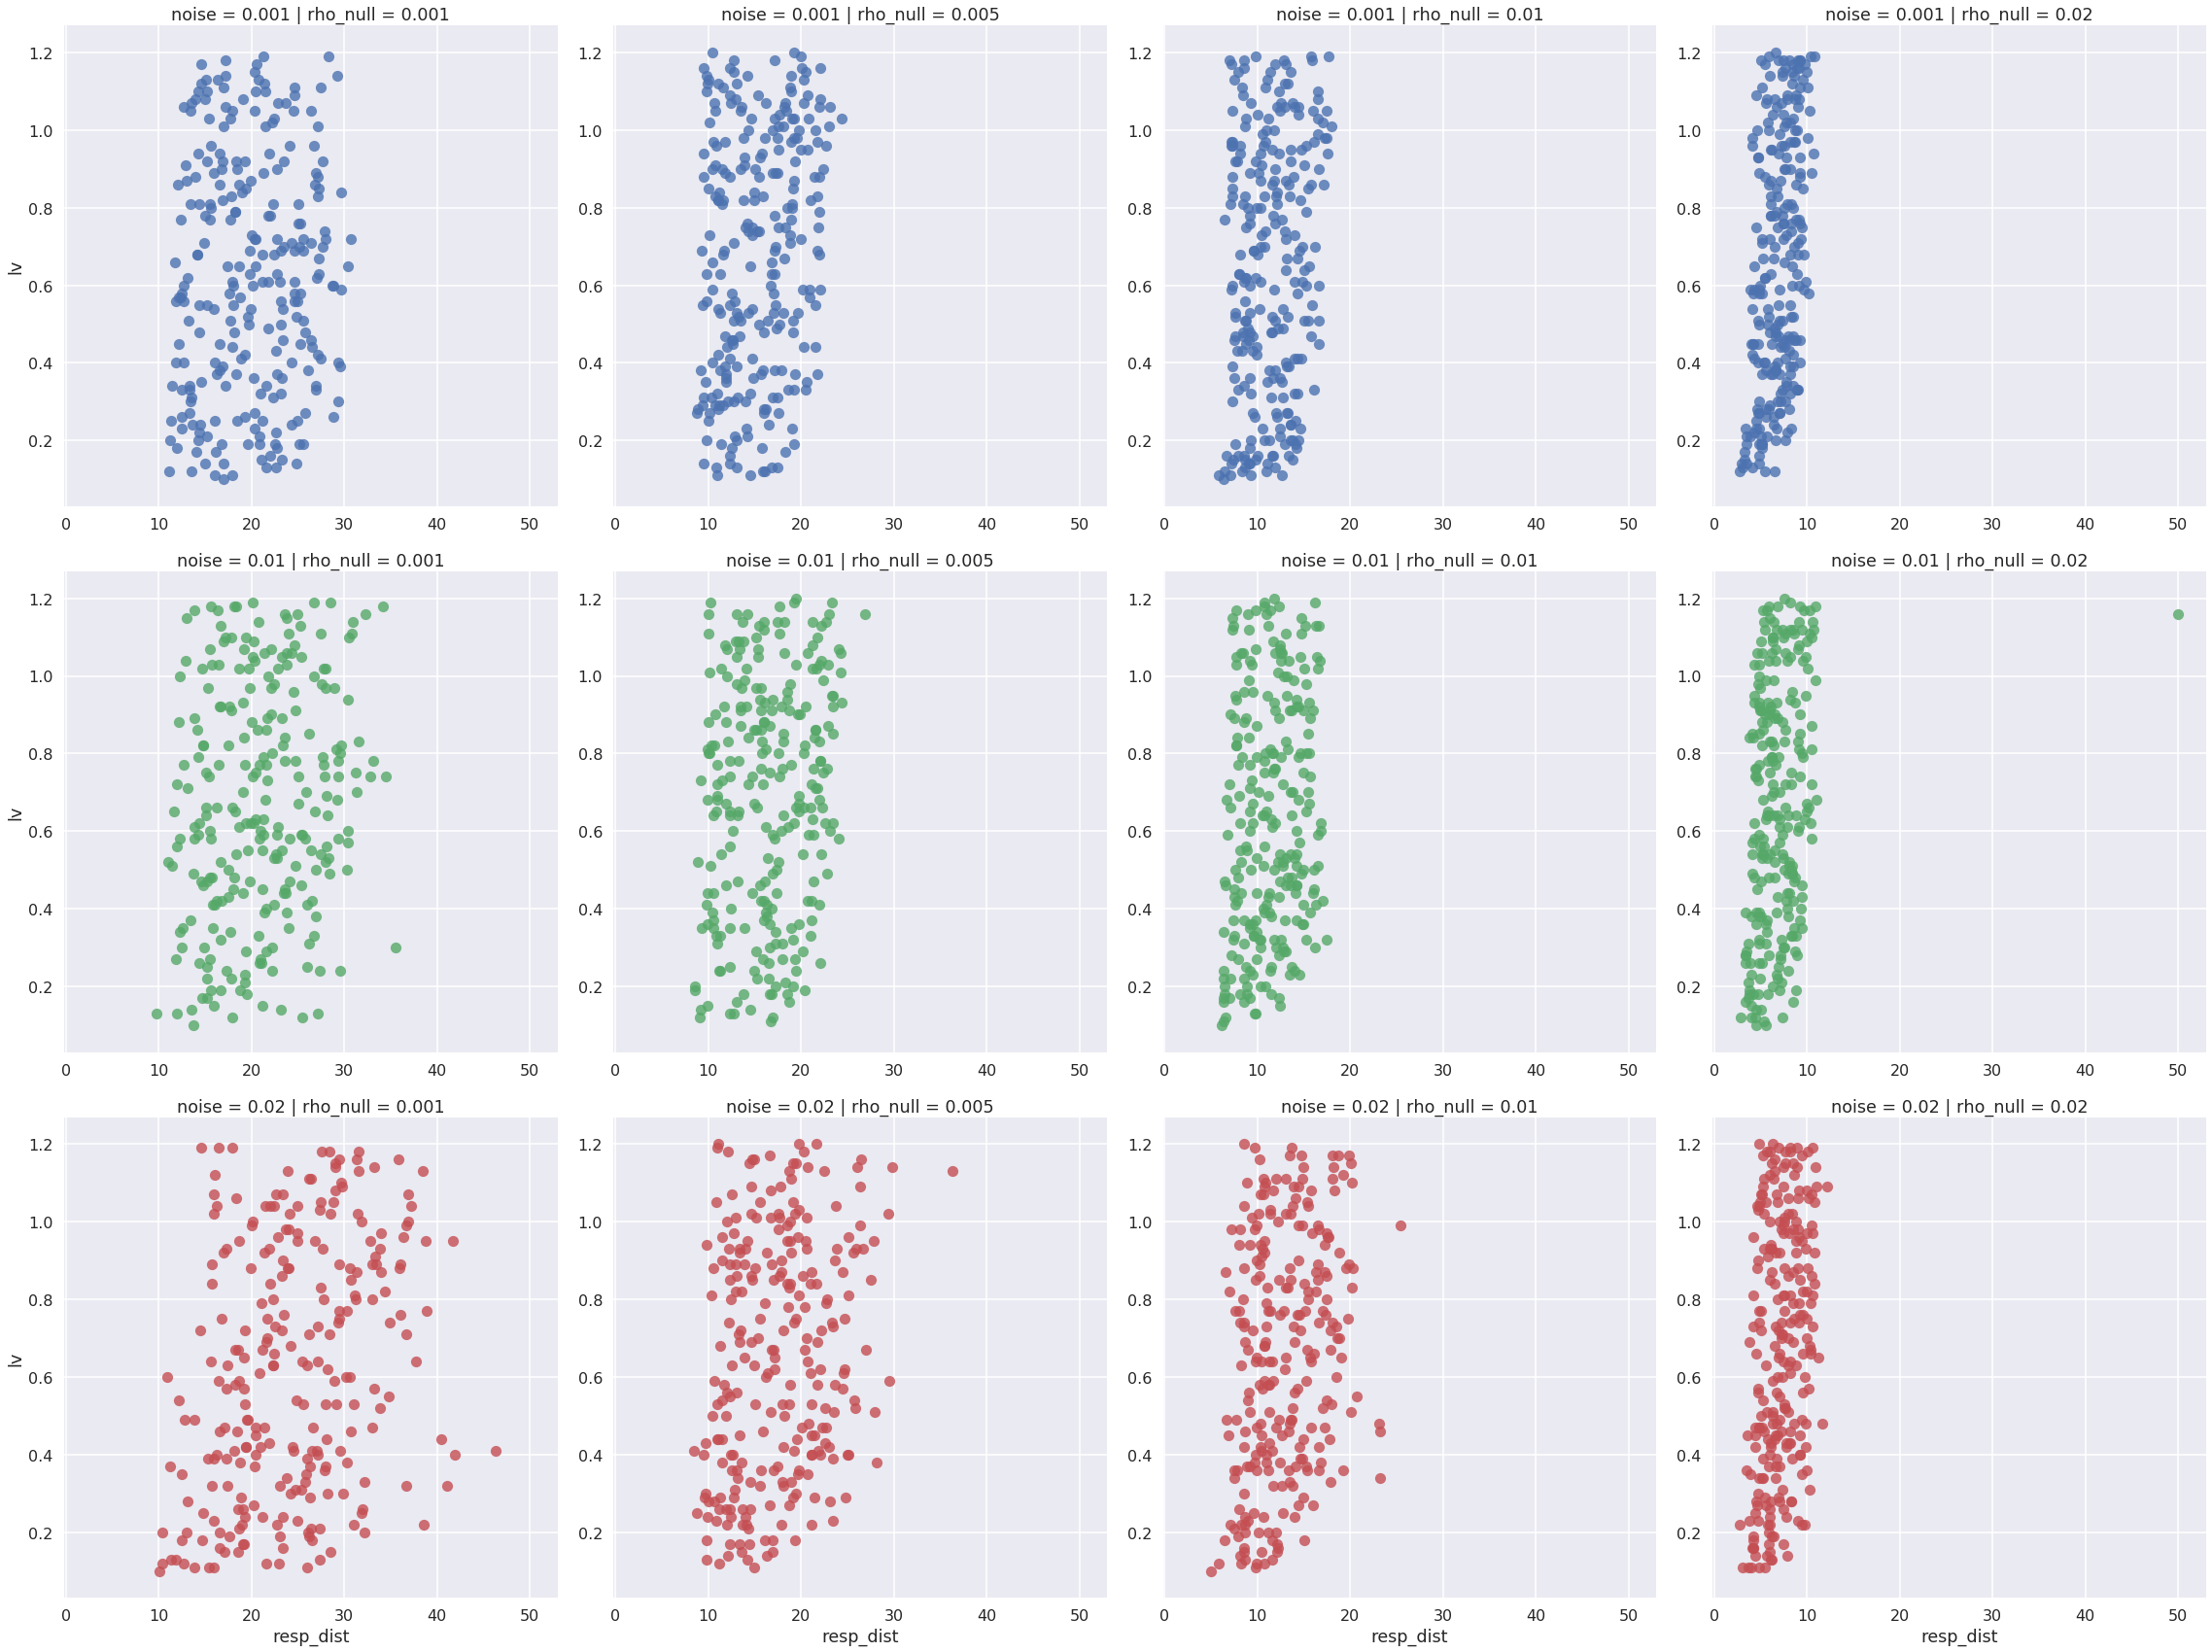

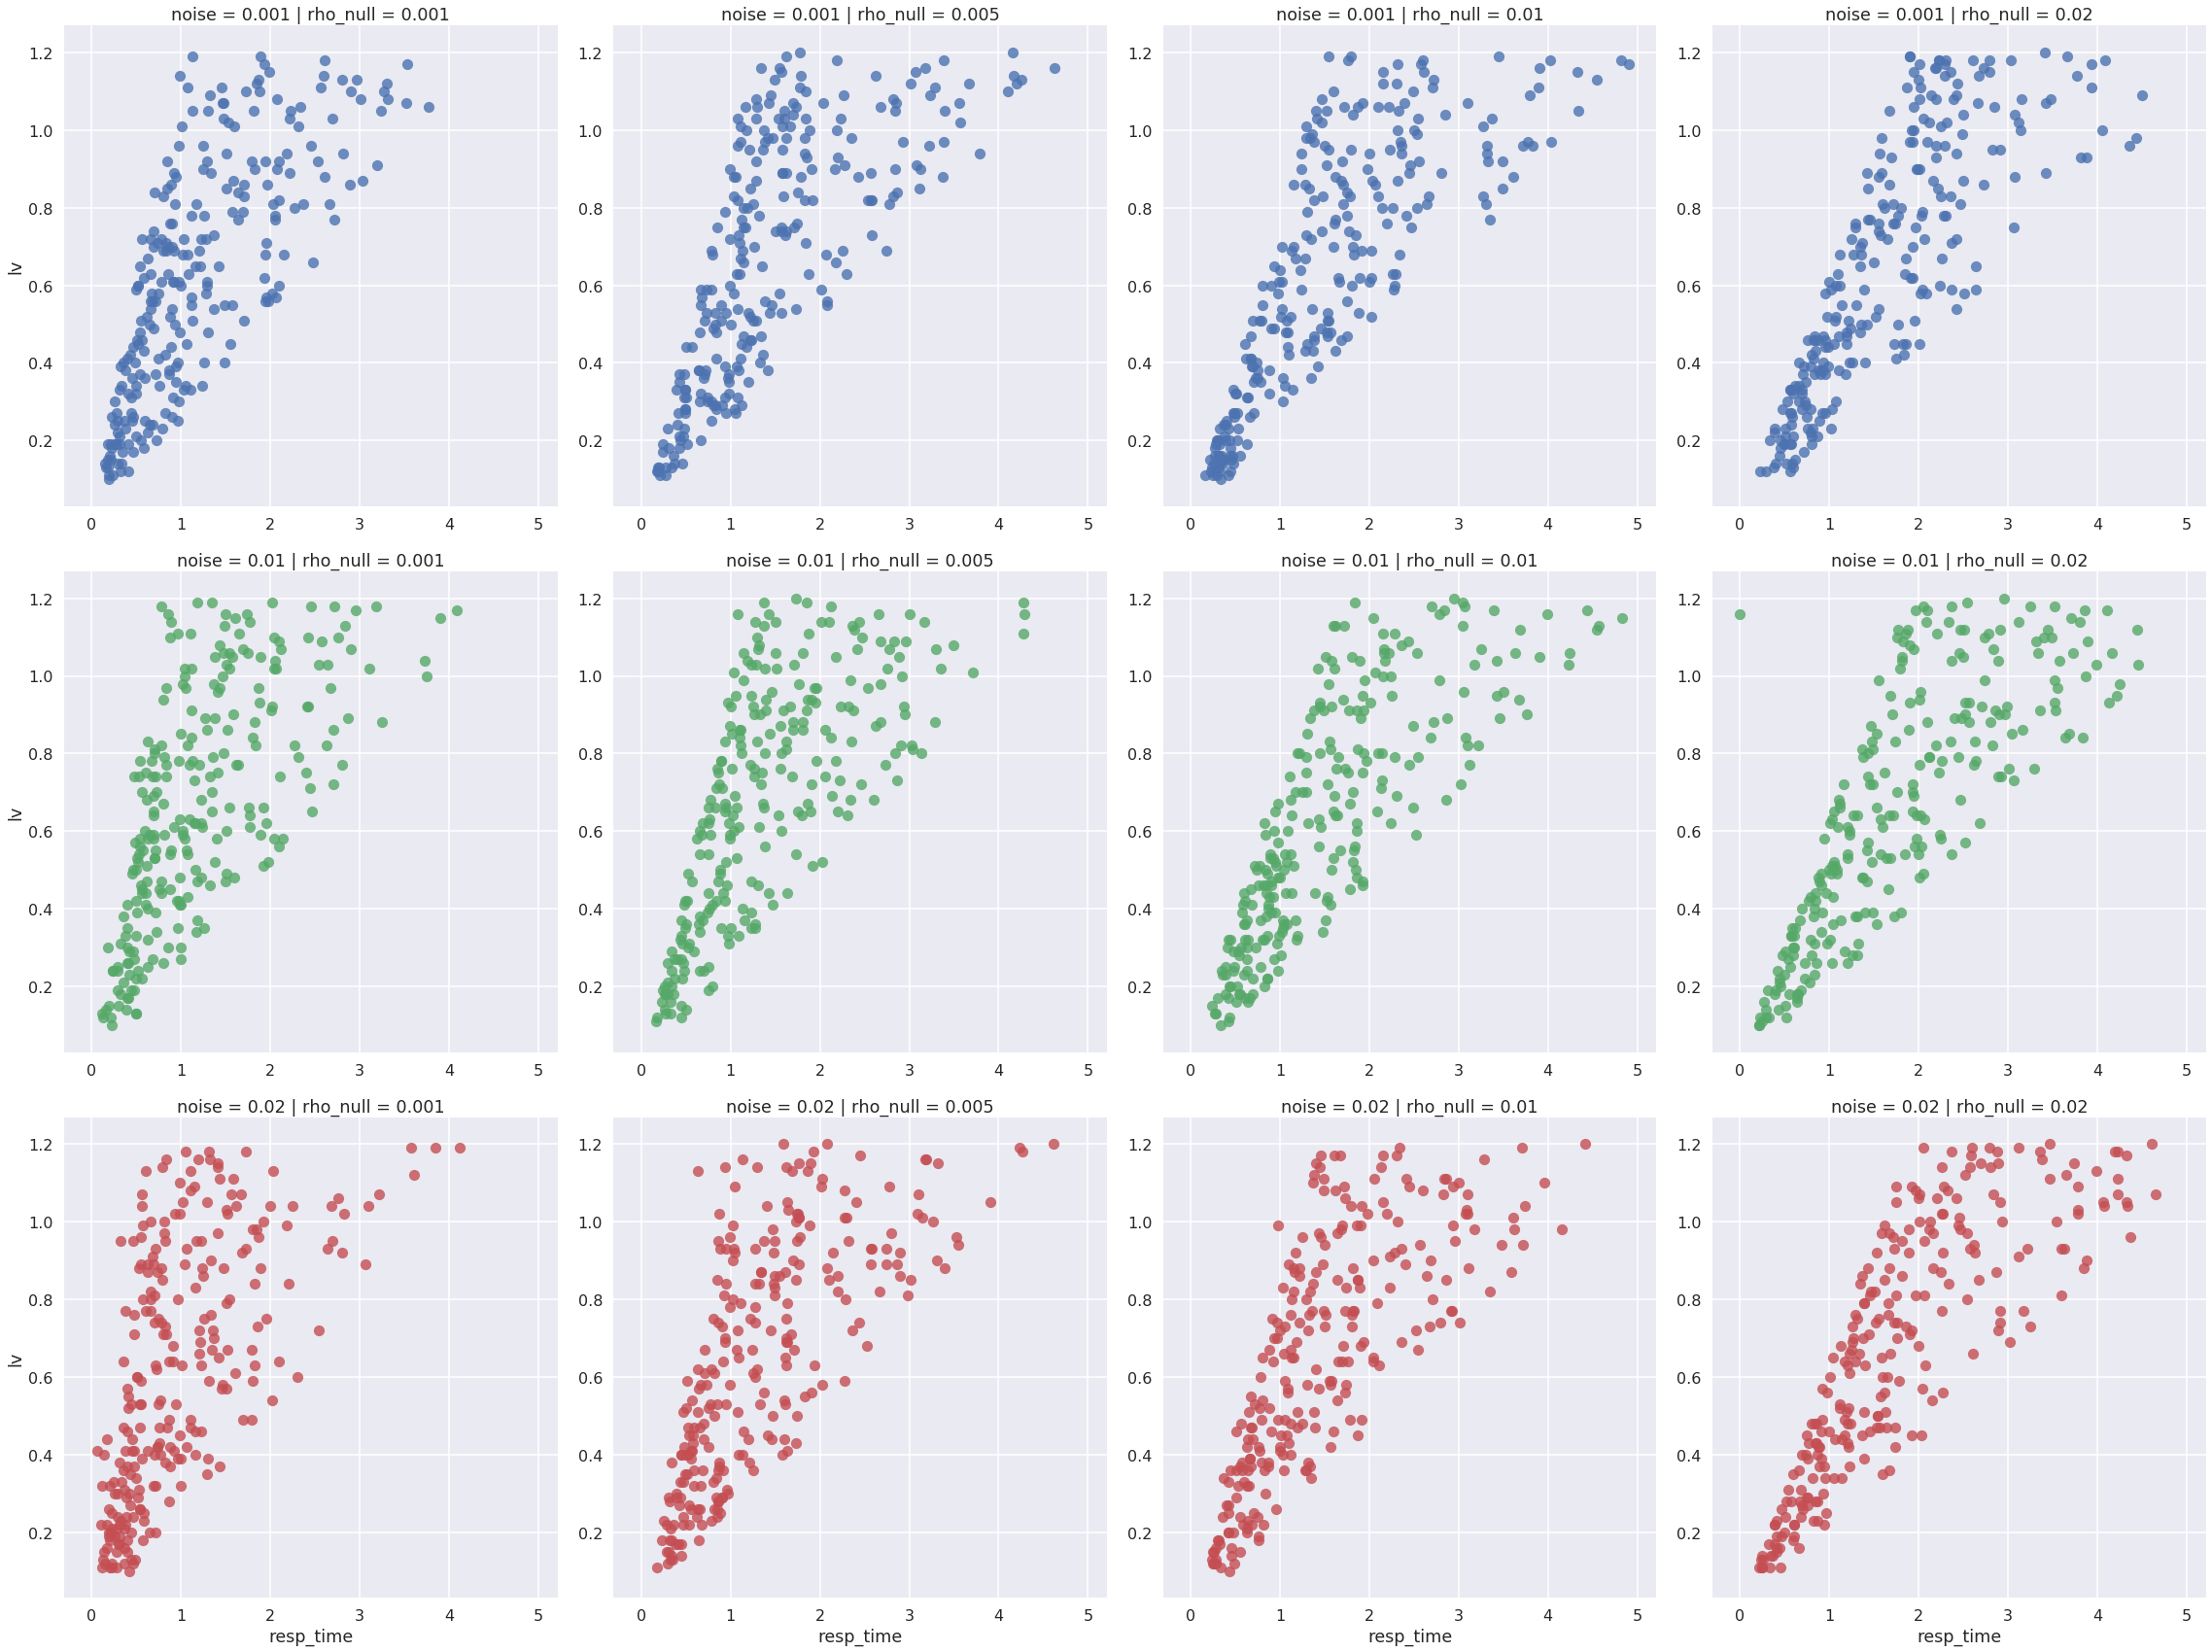

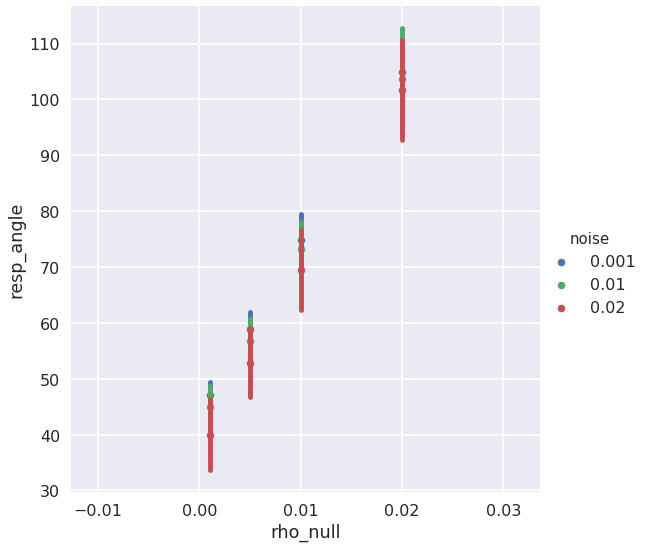

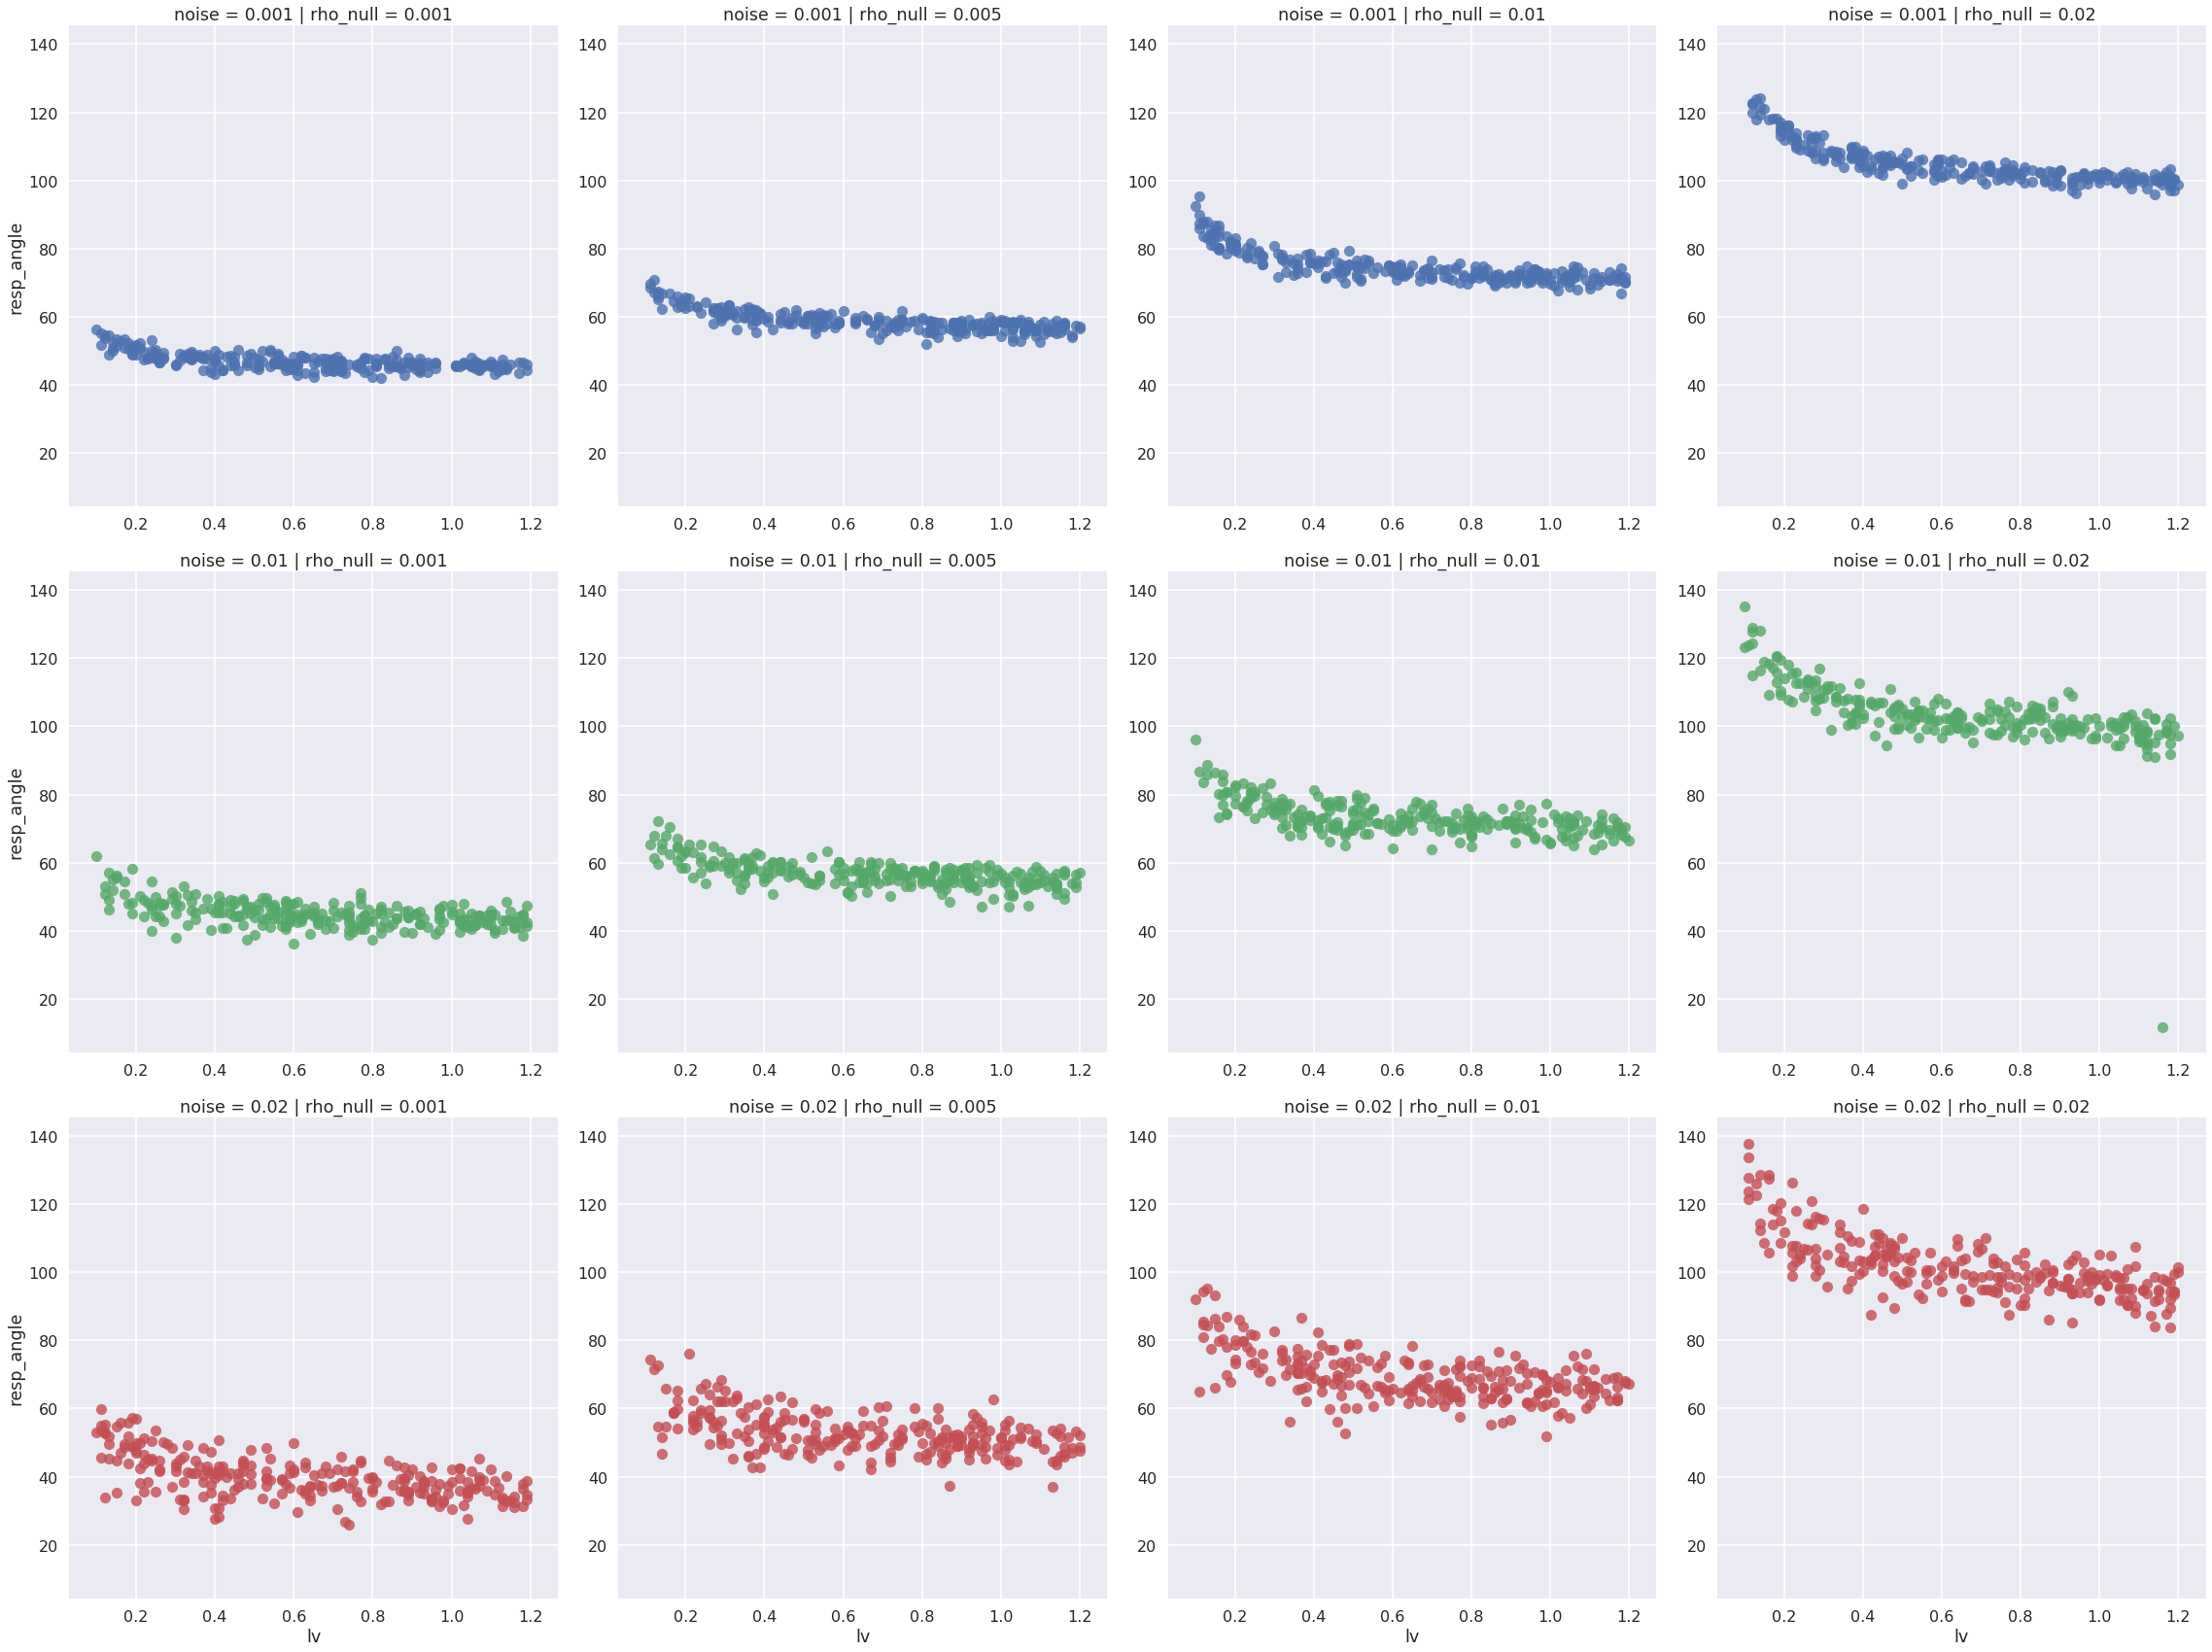

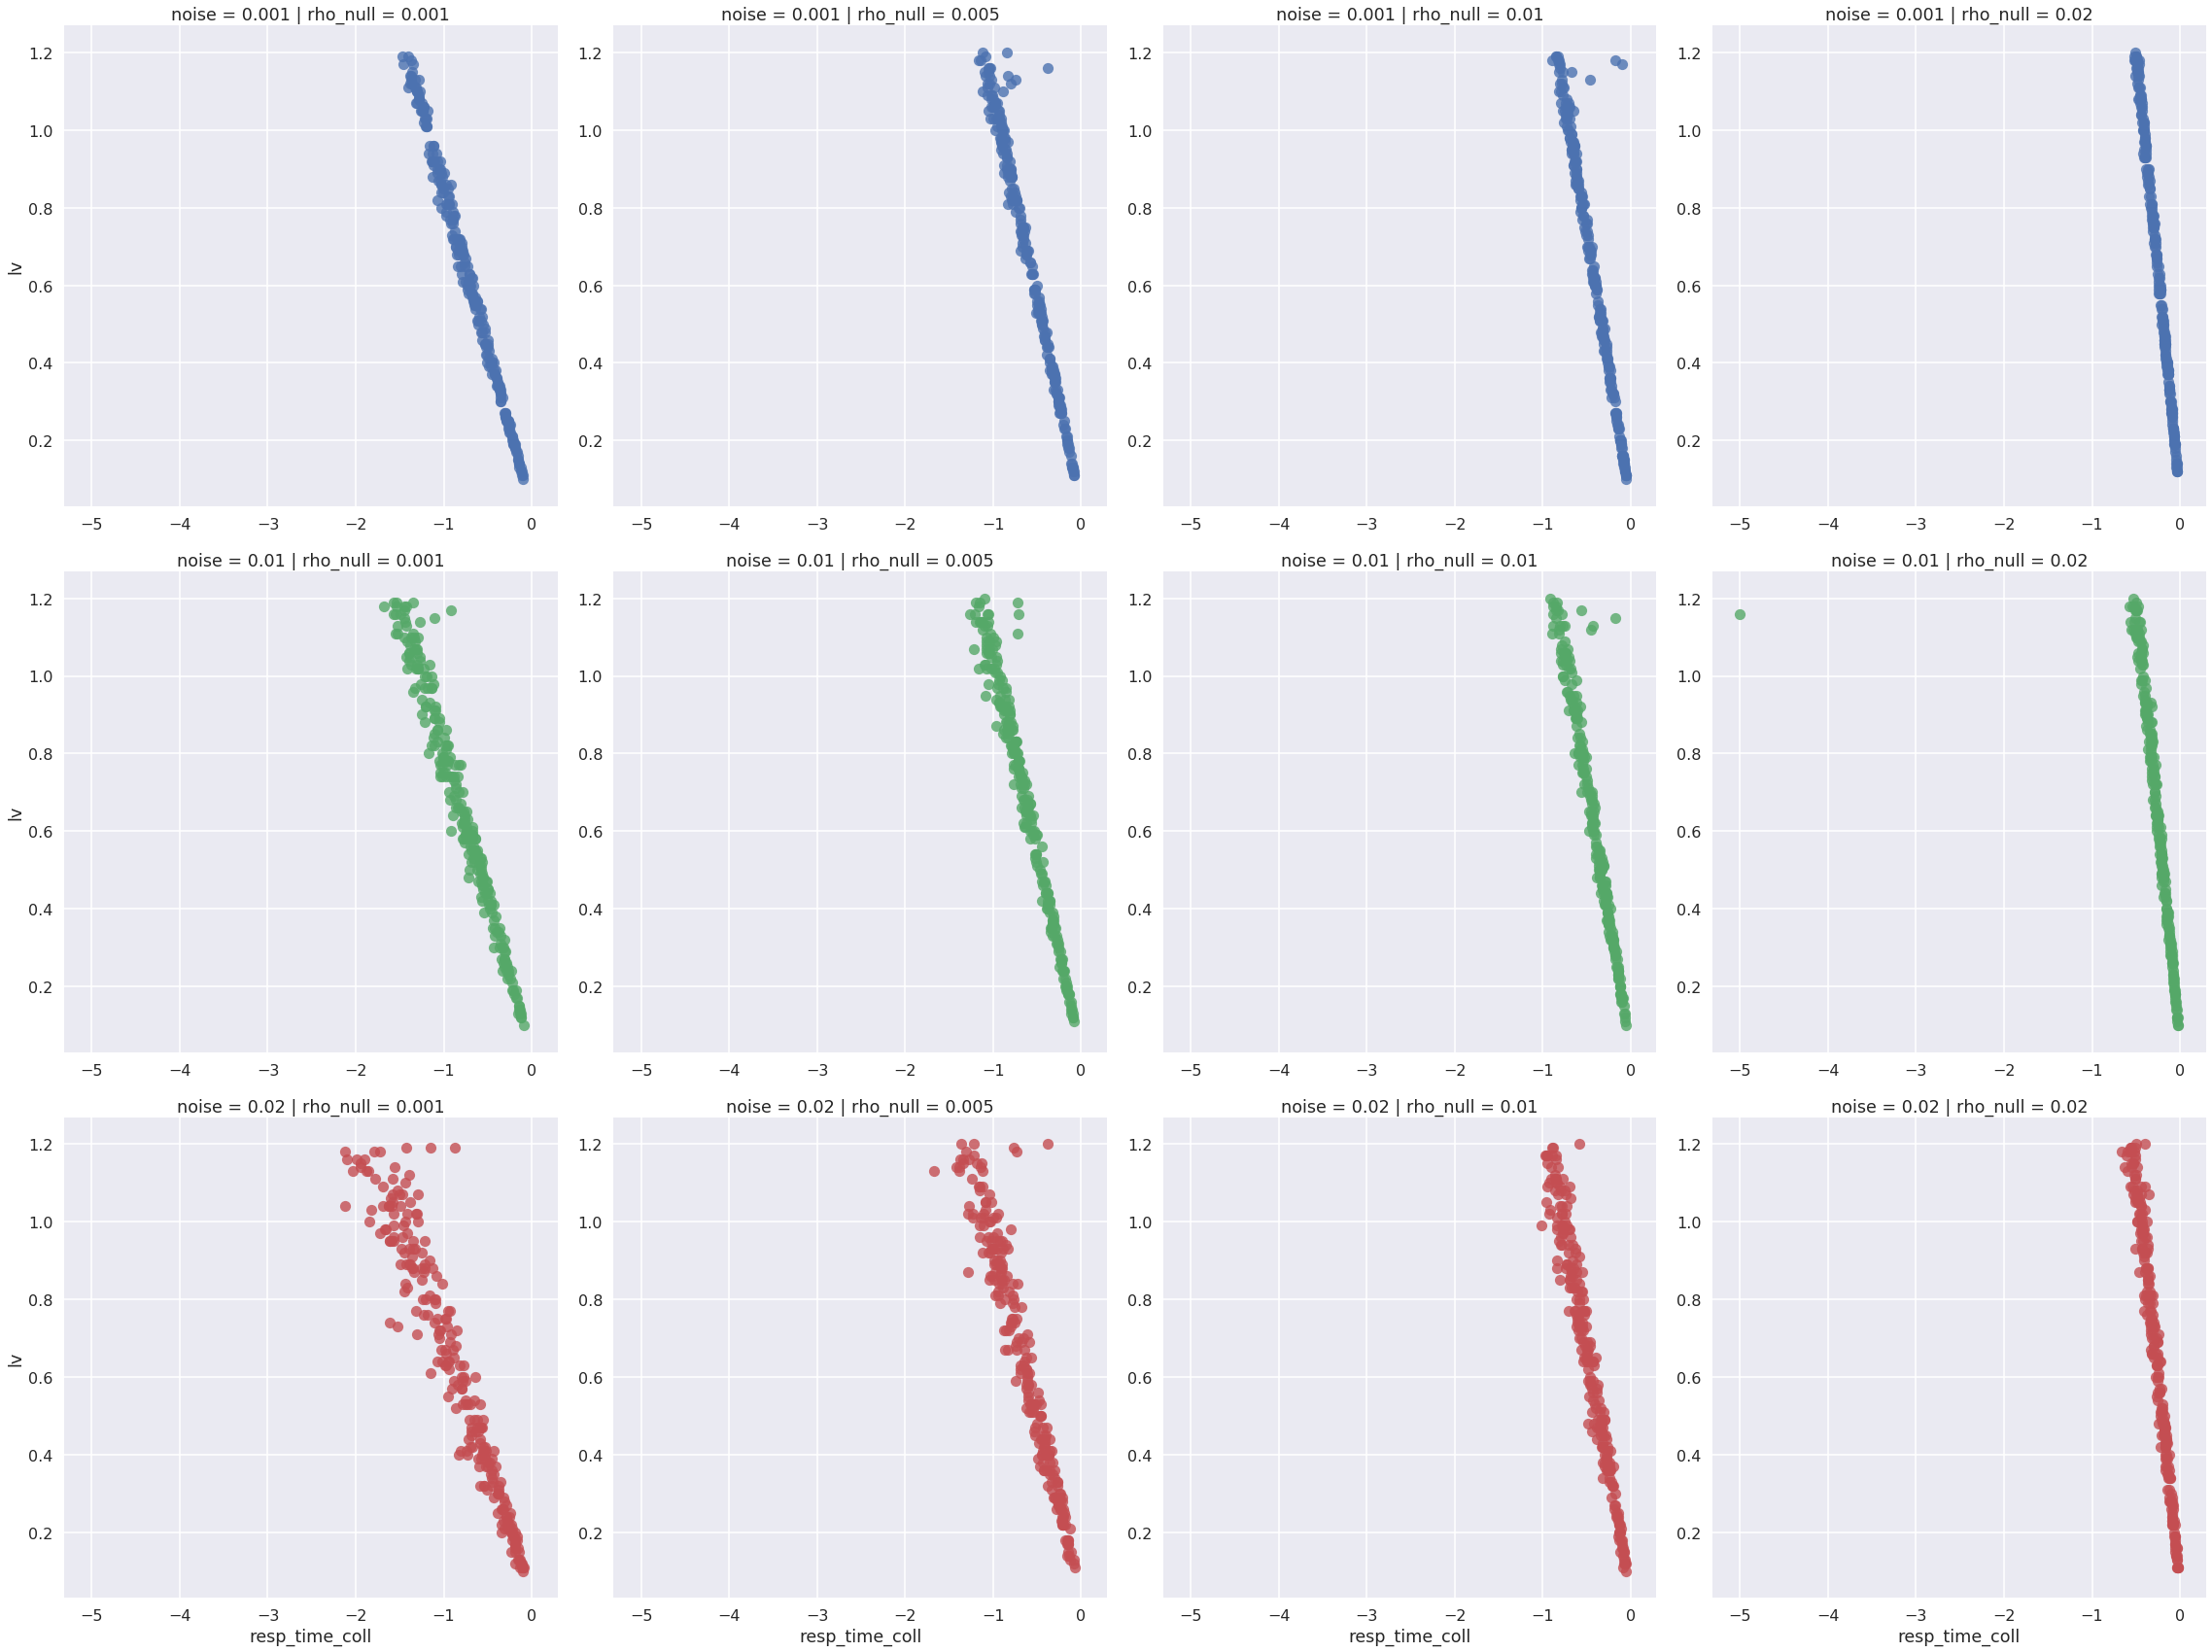

In [28]:
params = {'tau_m': 0.023,
          'e_l': -0.079,
          'r_m': 10*1e6, # MOhm
          'v_t': -0.061,
          'init_vm_std': 0.001,
          'vt_std': 0.001,
          'rho_null': 0.001,
          'tau_inh': 0.010,
          'rho_scale': 8*1e5,
          'dt': 0.001,
          'total_time': 5,
          'noise_std_exc': 5*1e-3,
          'noise_std_inh': 5*1e-3,
          'n_timepoints': int(total_time/dt),
          'm': 4,
          'b': 5}

rho_vals = np.array([1, 5, 10, 20])*1e-3
noisevals = np.array([1, 10, 20])*1e-3
nruns = 250
data_cols = ['resp_angle', 'resp_dist', 'resp_time', 'lv', 'stim_size', 'speed', 'rho_null', 'noise', 'resp_time_coll']
data_dict = dict([(col_name, []) for col_name in data_cols])

for noise_idx, noise in enumerate(noisevals):
    params['noise_std_exc'] = noise
    for rho_idx, rho_val in enumerate(rho_vals):
        params['rho_null'] = rho_val
        for i in np.arange(nruns):
            resp_angle, resp_dist, resp_time, lv, stim_size, speed, resp_time_coll = calc_response(params)
            resp_angle = np.round(resp_angle, decimals=1)
            resp_dist = np.round(resp_dist, decimals=1)
            resp_time = np.round(resp_time, decimals=3)
            lv = np.round(lv, decimals=2)
            stim_size = np.round(stim_size, decimals=1)
            speed = np.round(speed, decimals=1)
            resp_time_coll = np.round(resp_time_coll, decimals=3)
            result_values = [resp_angle, resp_dist, resp_time, lv, stim_size, speed, rho_val, noise, resp_time_coll]
            for col, value in zip(data_cols, result_values):
                data_dict[col].append(value)
                
df = pd.DataFrame(data_dict)
sns.set('poster')
g = sns.lmplot(x='resp_dist', y='lv', col='rho_null', row='noise', hue='noise', data=df, fit_reg=False, size=8)
g = sns.lmplot(x='resp_time', y='lv', col='rho_null', row='noise', hue='noise', data=df, fit_reg=False, size=8)
g = sns.lmplot(x='rho_null', y='resp_angle', hue='noise', data=df, fit_reg=False, size=8, x_estimator=np.mean, x_ci='sd')
g = sns.lmplot(x='lv', y='resp_angle', hue='noise', row='noise', col='rho_null', data=df, fit_reg=False, size=8)
g = sns.lmplot(x='resp_time_coll', y='lv', hue='noise', row='noise', col='rho_null', data=df, fit_reg=False, size=8)

## Time constant

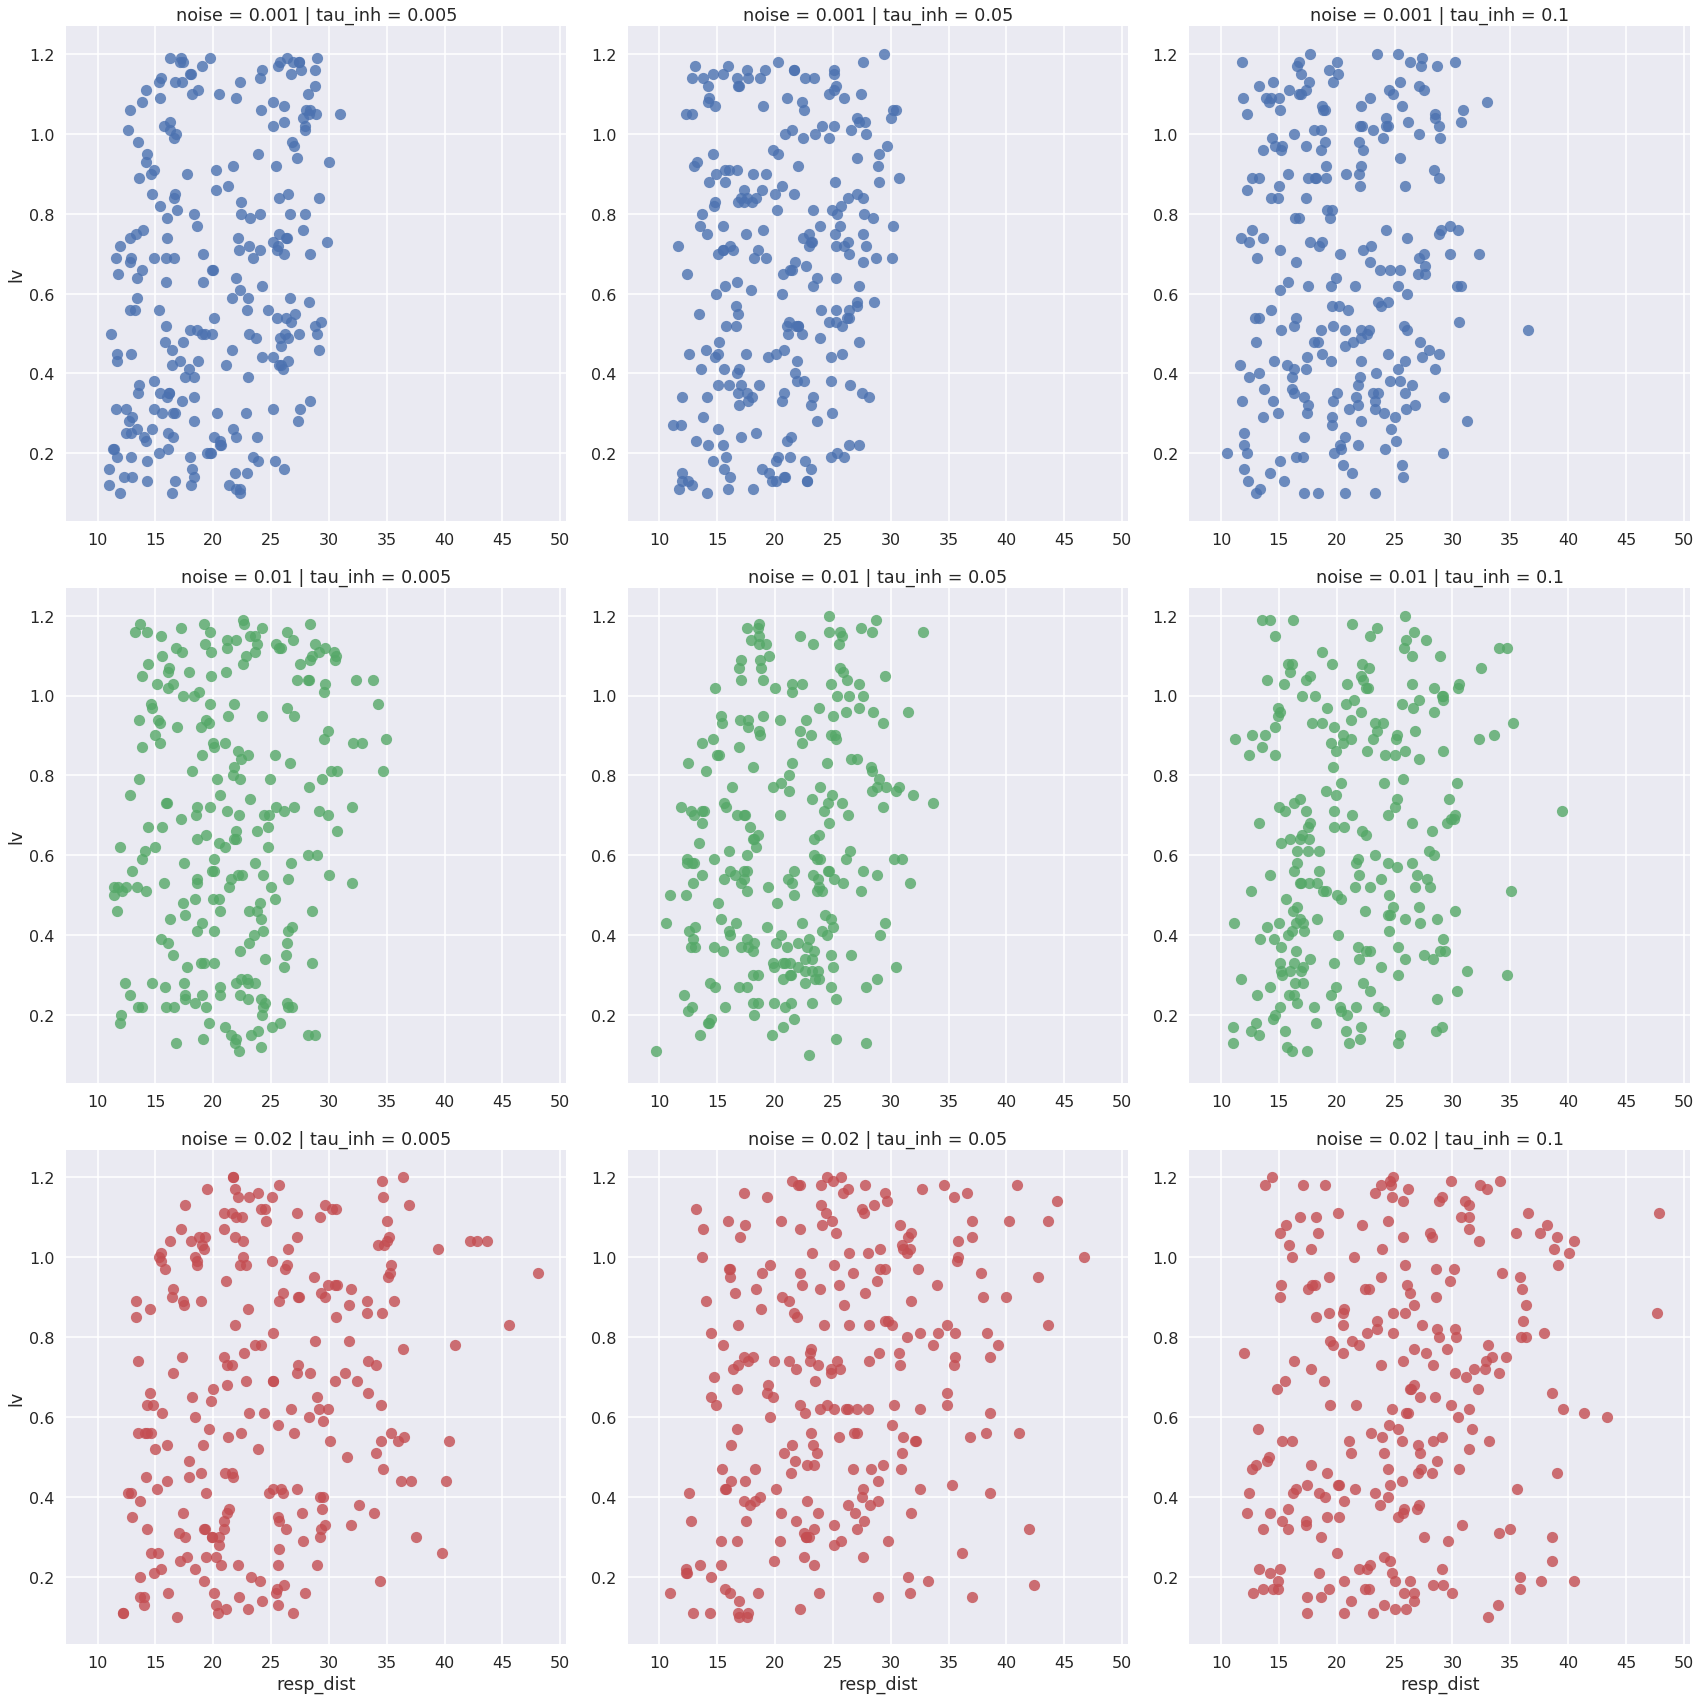

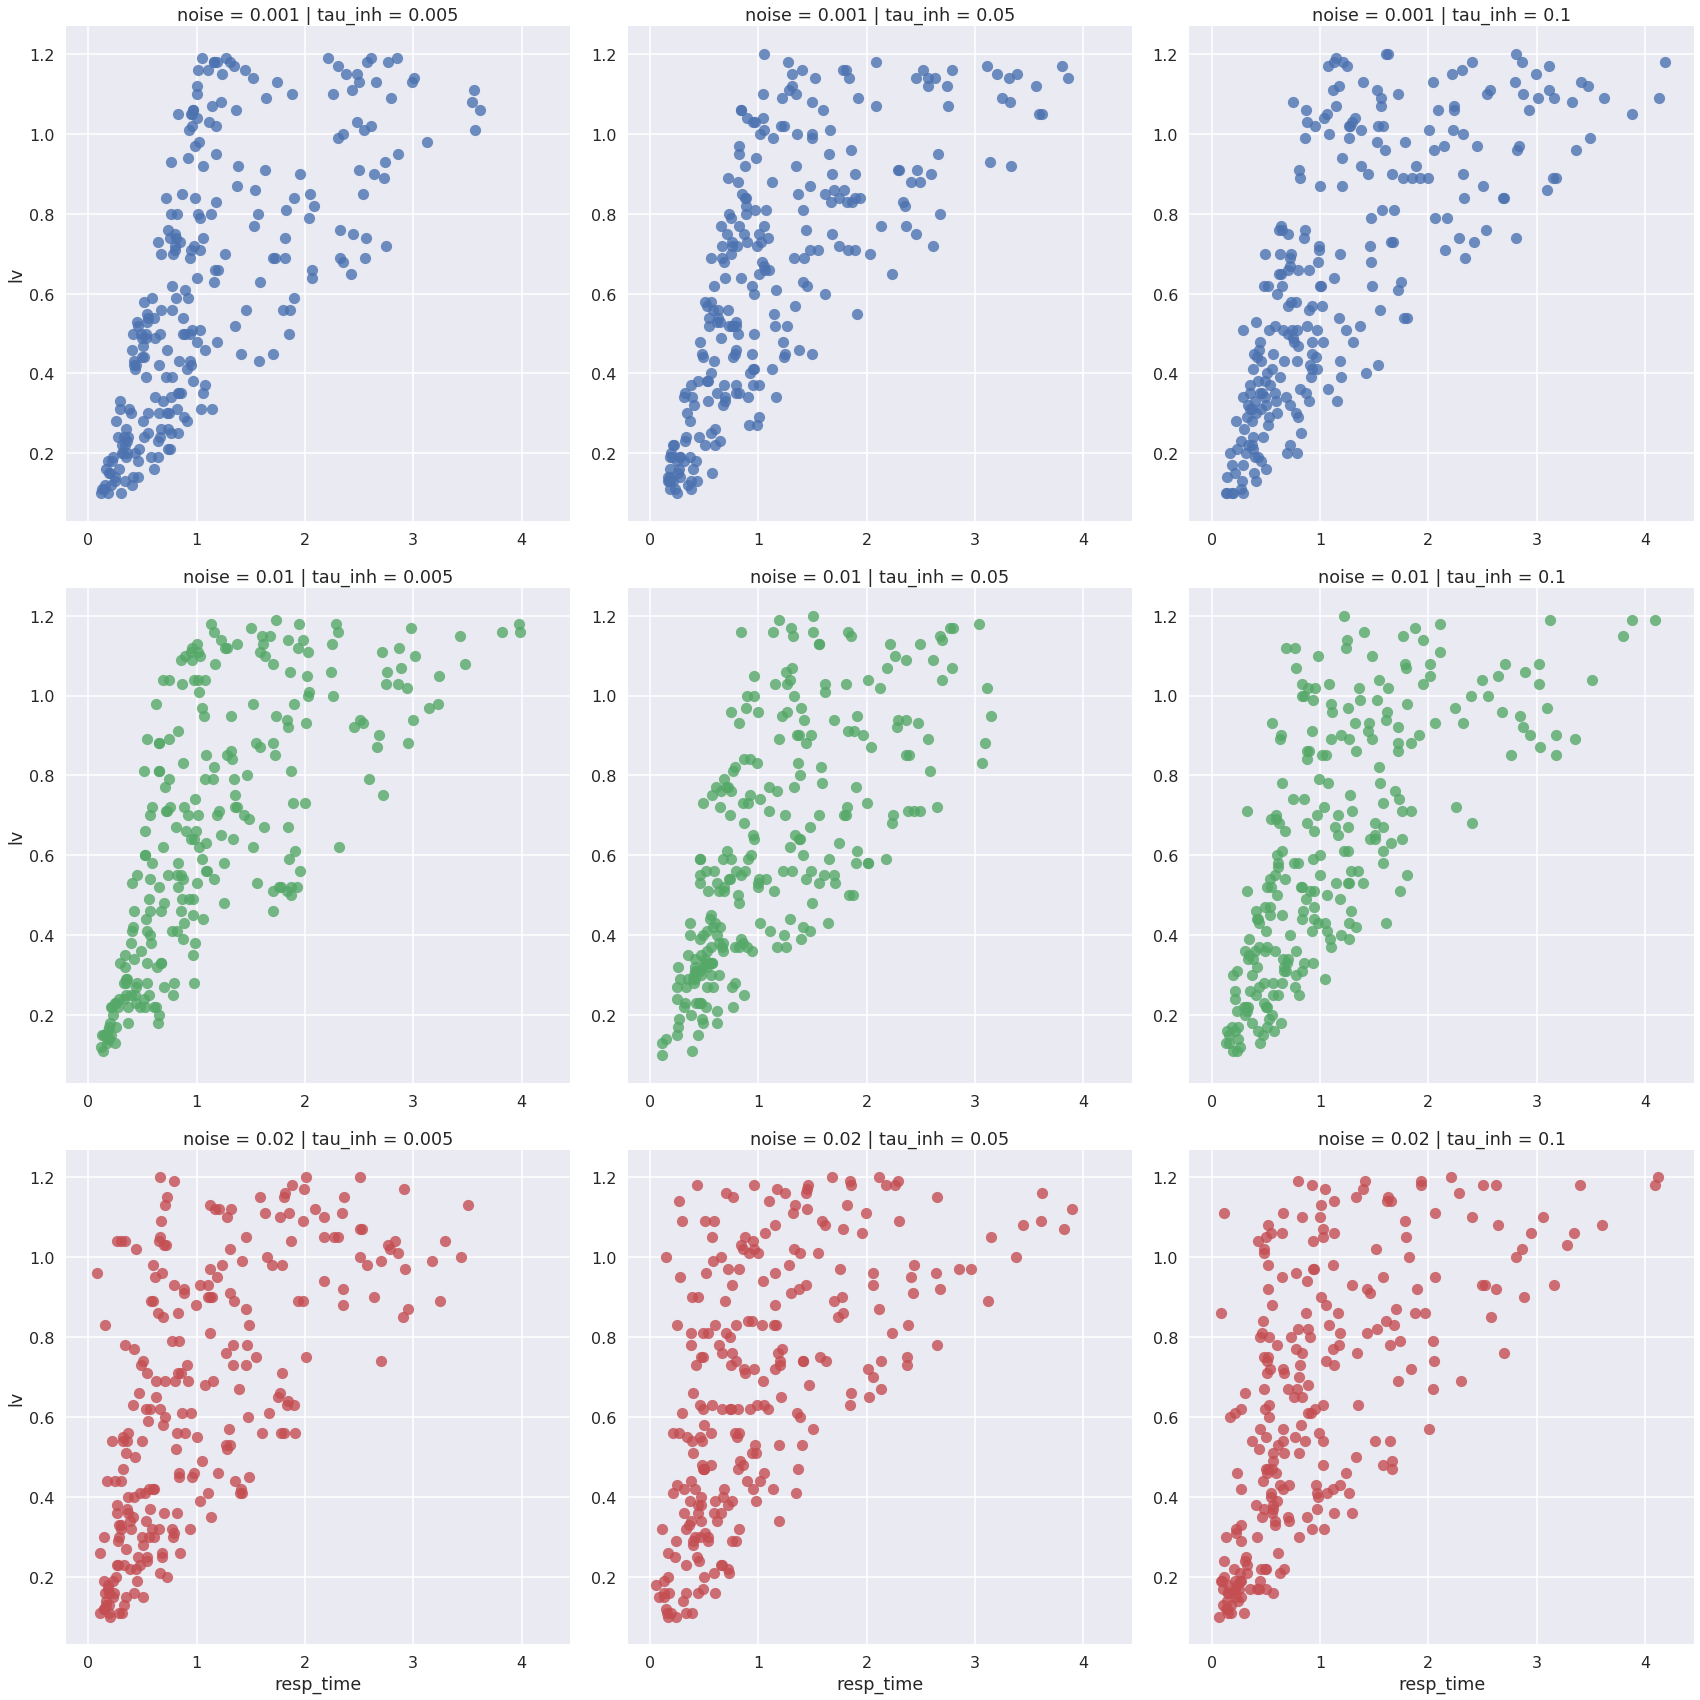

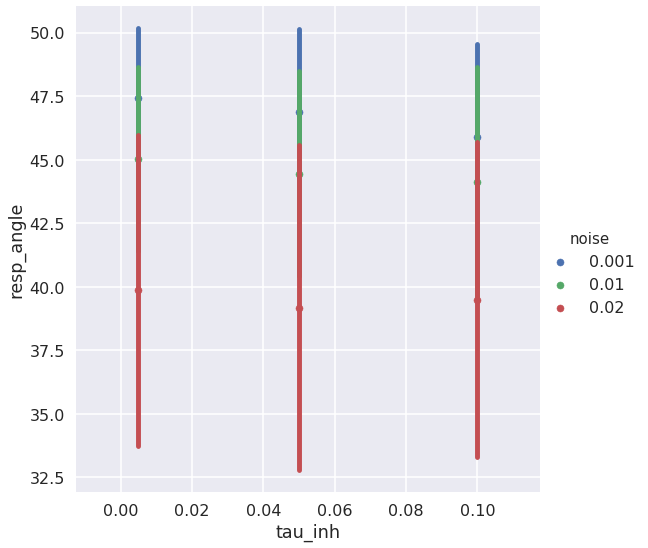

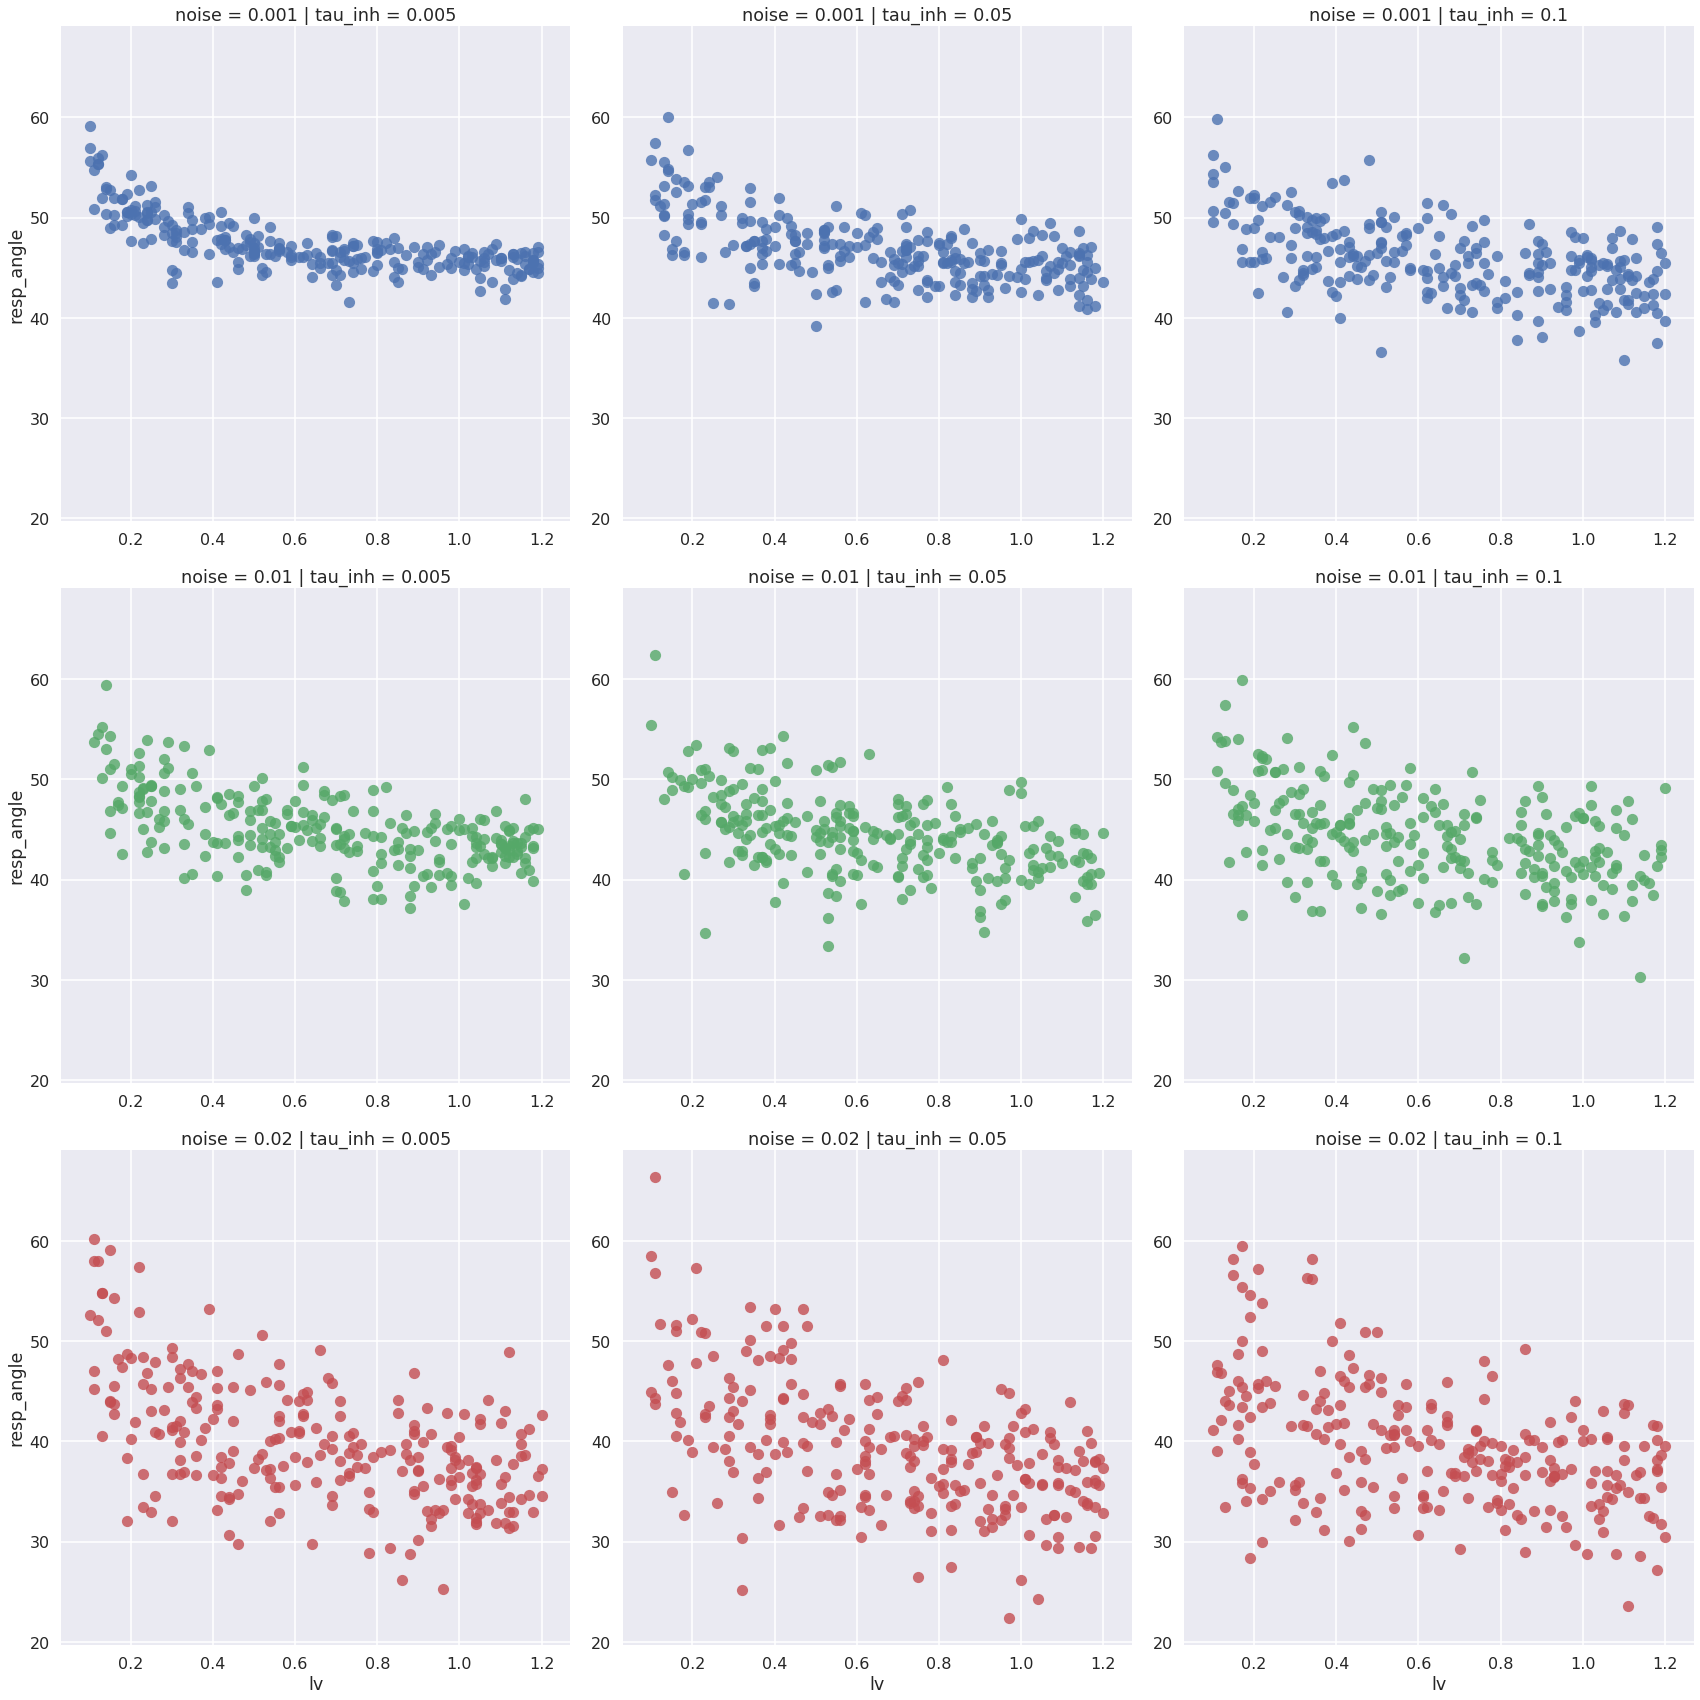

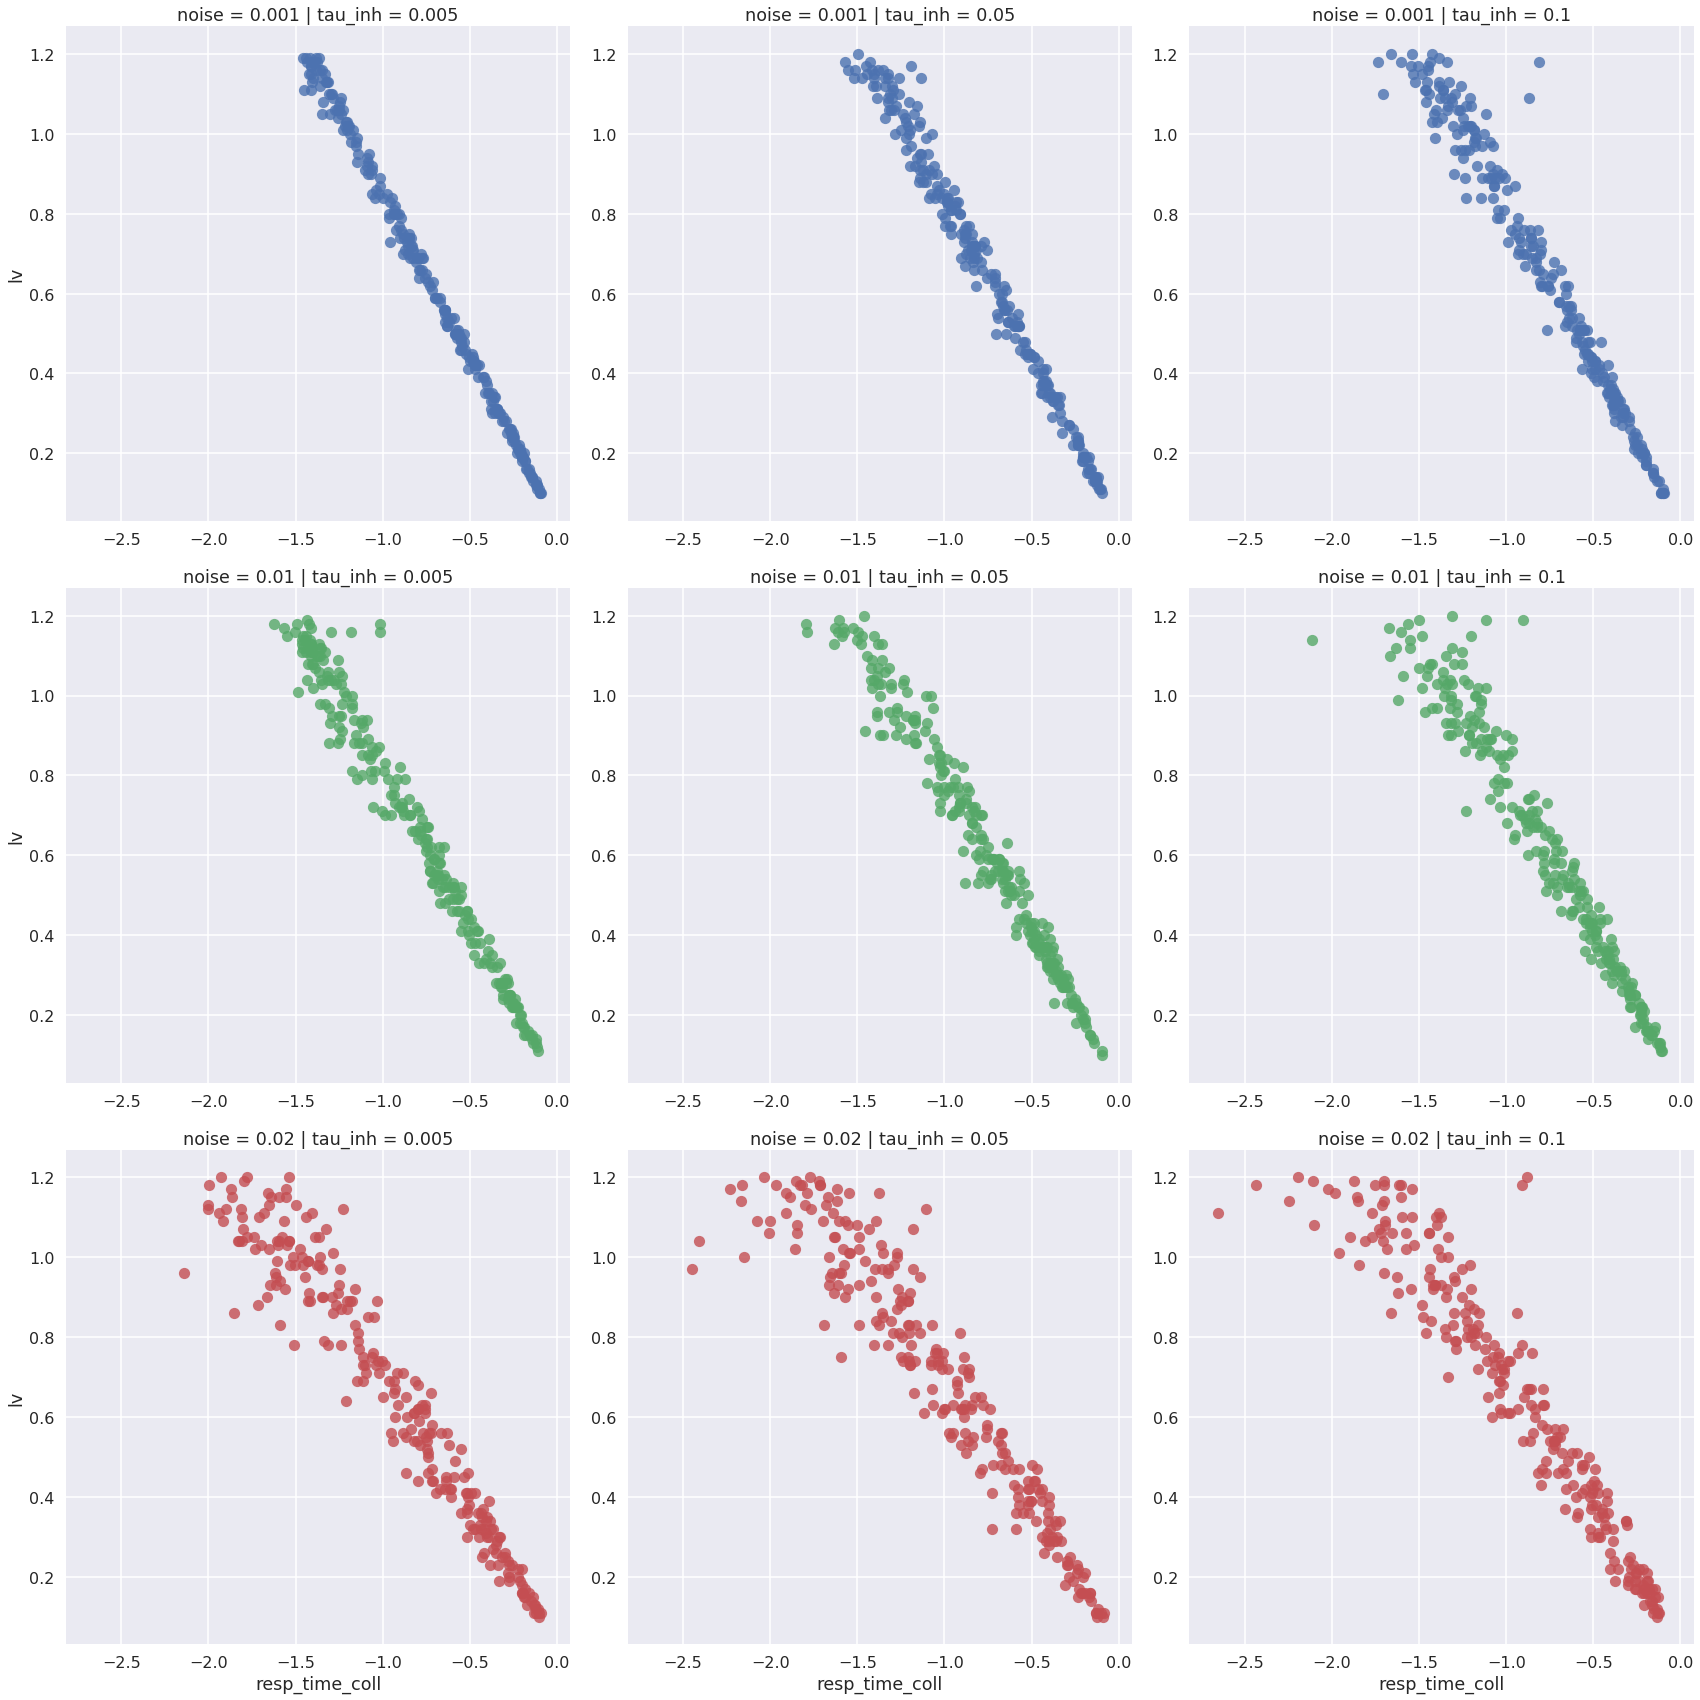

In [27]:
params = {'tau_m': 0.023,
          'e_l': -0.079,
          'r_m': 10*1e6, # MOhm
          'v_t': -0.061,
          'init_vm_std': 0.001,
          'vt_std': 0.001,
          'rho_null': 0.001,
          'tau_inh': 0.010,
          'rho_scale': 8*1e5,
          'dt': 0.001,
          'total_time': 5,
          'noise_std_exc': 5*1e-3,
          'noise_std_inh': 5*1e-3,
          'n_timepoints': int(total_time/dt),
          'm': 4,
          'b': 5}

rho_vals = np.array([5, 50, 100])*1e-3
noisevals = np.array([1, 10, 20])*1e-3
nruns = 250
data_cols = ['resp_angle', 'resp_dist', 'resp_time', 'lv', 'stim_size', 'speed', 'tau_inh', 'noise', 'resp_time_coll']
data_dict = dict([(col_name, []) for col_name in data_cols])

for noise_idx, noise in enumerate(noisevals):
    params['noise_std_exc'] = noise
    for rho_idx, rho_val in enumerate(rho_vals):
        params['tau_inh'] = rho_val
        for i in np.arange(nruns):
            resp_angle, resp_dist, resp_time, lv, stim_size, speed, resp_time_coll = calc_response(params)
            resp_angle = np.round(resp_angle, decimals=1)
            resp_dist = np.round(resp_dist, decimals=1)
            resp_time = np.round(resp_time, decimals=3)
            lv = np.round(lv, decimals=2)
            stim_size = np.round(stim_size, decimals=1)
            speed = np.round(speed, decimals=1)
            resp_time_coll = np.round(resp_time_coll, decimals=3)
            result_values = [resp_angle, resp_dist, resp_time, lv, stim_size, speed, rho_val, noise, resp_time_coll]
            for col, value in zip(data_cols, result_values):
                data_dict[col].append(value)
                
df = pd.DataFrame(data_dict)
sns.set('poster')
g = sns.lmplot(x='resp_dist', y='lv', col='tau_inh', row='noise', hue='noise', data=df, fit_reg=False, size=8)
g = sns.lmplot(x='resp_time', y='lv', col='tau_inh', row='noise', hue='noise', data=df, fit_reg=False, size=8)
g = sns.lmplot(x='tau_inh', y='resp_angle', hue='noise', data=df, fit_reg=False, size=8, x_estimator=np.mean, x_ci='sd')
g = sns.lmplot(x='lv', y='resp_angle', hue='noise', row='noise', col='tau_inh', data=df, fit_reg=False, size=8)
g = sns.lmplot(x='resp_time_coll', y='lv', hue='noise', row='noise', col='tau_inh', data=df, fit_reg=False, size=8)